### **Author** : Vannessa Juarez

## Importing Libraries

In [1]:
import sys
from pathlib import Path

#usual suspects
import pandas as pd
import numpy as np
import seaborn as sns

#for metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf


#for notebook Jupyter
%matplotlib inline

#Data visualizations
import matplotlib.pyplot as plt
import joypy
from ydata_profiling import ProfileReport #need to add for compatibility

#data preproccessing
from sklearn.preprocessing import StandardScaler
#K means
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Spatial Dynamics
from libpysal.weights import Queen
import esda
import geopandas as gpd
from scipy.spatial.distance import cdist

#print("python:", sys.executable)
#print("pandas:", pd.__version__)
#avoid the warnings
import warnings
warnings.filterwarnings('ignore')


C:\Users\Owner\anaconda3\envs\vsproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [2]:
#my directory of the data- change to your directory of data
DATA_DIR = Path(r"C:\Users\Owner\Documents\datsci\rents")#change to where the csv files are, this is where we will read the data

#where the outputs are  gonna be
OUT_DIR  = Path(r"C:\Users\Owner\Documents\GitHub\DAT490\data") #change to where you want the data to go
OUT_DIR.mkdir(parents=True, exist_ok=True)
METRO_FILES = {
    "phoenix":     DATA_DIR / "final_zcta_dataset_phoenix.csv",
    "memphis":     DATA_DIR / "final_zcta_dataset_memphis.csv",
    "los_angeles": DATA_DIR / "final_zcta_dataset_los_angeles.csv",
    "dallas":      DATA_DIR / "final_zcta_dataset_dallas.csv",
}
#new directory for names
METRO_NAMES = {
    "phoenix": "Phoenix-Mesa-Chandler, AZ",
    "memphis": "Memphis, TN-MS-AR",
    "los_angeles": "Los Angeles-Long Beach-Anaheim, CA",
    "dallas": "Dallas-Fort Worth-Arlington, TX"
}


#keep this for spatial analysis
METRO_CONFIGS = {
    "phoenix": {
        "name": "Phoenix-Mesa-Chandler, AZ",
        "cbsa_code": "38060",
        "state_fips": "04",
        "county_fips_list": ["013", "021"],
        "zip_prefixes": ["85"],
        "utm_zone": 32612
    },
    "memphis": {
        "name": "Memphis, TN-MS-AR",
        "cbsa_code": "32820",
        "state_fips": "47",
        "county_fips_list": ["157", "047", "033"],
        "zip_prefixes": ["38", "72"],
        "utm_zone": 32616
    },
    "los_angeles": {
        "name": "Los Angeles-Long Beach-Anaheim, CA",
        "cbsa_code": "31080",
        "state_fips": "06",
        "county_fips_list": ["037"],
        "zip_prefixes": ["90", "91"],
        "utm_zone": 32611
    },
    "dallas": { #keeping dfw as it is to simplify things, just added collin fipscode
        #ping me for more cbsa codes if desired.. i was able to find them
        "name": "Dallas-Fort Worth-Arlington, TX",
        "cbsa_code": "19100",
        "state_fips": "48",
        "county_fips_list": ["113", "085", "121", "257", "439"],
        "zip_prefixes": ["75", "76"],
        "utm_zone": 32614
    }
}


In [3]:
def light_clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # date time formatting
    if "period" in df.columns:
        df["period"] = pd.to_datetime(df["period"], errors="coerce")

    # income_segment is encoded as "Low", "Medium" and "High"; we will make sure it is categorical
    if "income_segment" in df.columns:
        # Convert to ordered categorical
        df["income_segment"] = pd.Categorical(
            df["income_segment"],
            categories=["Low", "Medium", "High"],
            ordered=True
        )

    # enforce numeric type where it needs to be just in case
    for col in [
        "rent_to_income", "pct_rent_burden_30", "pct_rent_burden_50", "zori", "commute_min_proxy",
        "pct_commute_lt10", "pct_commute_10_19", "pct_commute_20_29", "pct_commute_30_44",
        "pct_commute_45_59", "pct_commute_60_plus", "ttw_total", "pct_drive_alone", "pct_carpool",
        "pct_car", "pct_transit", "pct_walk", "pct_wfh", "total_pop", "pct_white", "pct_black",
        "pct_asian", "pct_hispanic", "pct_other", "median_income", "stops_per_km2"
    ]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

In [4]:
#this is our join. We will be keeping the above directory untouched for now
frames = []

for key, path in METRO_FILES.items():
    print(f"Loading {METRO_NAMES[key]} from {path}...")
    
    temp = pd.read_csv(path, low_memory=False)
    temp = light_clean(temp)
    
    # Tag the metro identity
    temp["metro_key"]  = key
    temp["metro_name"] = METRO_NAMES[key]
    
    frames.append(temp)

df = pd.concat(frames, ignore_index=True)

df.shape, df.head()

Loading Phoenix-Mesa-Chandler, AZ from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_phoenix.csv...
Loading Memphis, TN-MS-AR from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_memphis.csv...
Loading Los Angeles-Long Beach-Anaheim, CA from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_los_angeles.csv...
Loading Dallas-Fort Worth-Arlington, TX from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_dallas.csv...


((670, 31),
    ZCTA5CE  rent_to_income  pct_rent_burden_30  pct_rent_burden_50  \
 0    85003        0.371199           53.103617           10.291375   
 1    85004        0.365427           46.098395            8.466977   
 2    85006        0.243321           47.307833            7.905786   
 3    85007        0.261612           46.842588            7.926962   
 4    85008        0.247838           33.522505            2.522608   
 
           zori  commute_min_proxy  pct_commute_lt10  pct_commute_10_19  \
 0  1781.142157          21.953953         12.433286          41.114363   
 1  1824.106878          22.417636         14.027317          25.016263   
 2  1438.695628          24.451310          9.770753          25.927541   
 3  1450.002646          24.528932         12.625435          27.990609   
 4  1457.858483          25.473128          7.677261          35.097420   
 
    pct_commute_20_29  pct_commute_30_44  ...  pct_black  pct_asian  \
 0          27.529004          14.044

## Exploratory Data Analysis

In [5]:
#ok so we can start a basic EDA
#shape(649,11)
df.describe(include='all')


,ZCTA5CE,rent_to_income,pct_rent_burden_30,pct_rent_burden_50,zori,commute_min_proxy,pct_commute_lt10,pct_commute_10_19,pct_commute_20_29,pct_commute_30_44,...,pct_black,pct_asian,pct_hispanic,pct_other,median_income,income_segment,stops_per_km2,period,metro_key,metro_name
count,670.000000,655.000000,665.000000,665.000000,583.000000,666.000000,666.000000,666.000000,666.000000,666.000000,...,670.000000,670.000000,670.000000,670.000000,6.700000e+02,670,670.000000,583,670,670
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,4,4
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Medium,NaN,NaN,los_angeles,"Los Angeles-Long Beach-Anaheim, CA"
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,332,NaN,NaN,270,270
mean,80762.252239,0.255762,46.284197,7.781516,2326.002617,30.948368,9.108996,25.155056,21.311272,24.880175,...,13.136082,9.268689,32.283109,4.821335,-5.208623e+06,NaN,3.409647,2025-09-30 00:00:00,NaN,NaN
min,38002.000000,0.105905,0.000000,0.000000,917.729377,11.008447,0.384615,5.742297,1.525886,0.000000,...,0.000000,0.000000,0.000000,0.000000,-6.666667e+08,NaN,0.000000,2025-09-30 00:00:00,NaN,NaN
25%,75253.250000,0.220620,39.453544,3.590572,1666.488095,27.398977,6.064468,20.920550,18.024307,21.192416,...,3.107975,1.887012,14.207964,2.900720,6.545853e+04,NaN,0.002793,2025-09-30 00:00:00,NaN,NaN
50%,85253.500000,0.249991,46.709805,5.486361,2108.942230,31.112406,7.959368,24.769757,20.954612,25.106000,...,6.086072,5.277773,25.428385,4.415705,8.740896e+04,NaN,1.053770,2025-09-30 00:00:00,NaN,NaN
75%,90302.750000,0.284105,53.327727,8.959445,2747.971722,34.339365,10.867190,29.085344,24.471987,28.406079,...,16.086508,11.808895,47.631979,6.015186,1.120257e+05,NaN,4.766843,2025-09-30 00:00:00,NaN,NaN
max,91803.000000,0.593256,100.000000,83.985330,12446.388889,48.623288,63.223364,59.166667,48.089202,45.173974,...,94.501678,69.246905,97.576546,77.895753,2.395182e+05,NaN,53.879431,2025-09-30 00:00:00,NaN,NaN


In [6]:
print(df.columns)

Index(['ZCTA5CE', 'rent_to_income', 'pct_rent_burden_30', 'pct_rent_burden_50',
       'zori', 'commute_min_proxy', 'pct_commute_lt10', 'pct_commute_10_19',
       'pct_commute_20_29', 'pct_commute_30_44', 'pct_commute_45_59',
       'pct_commute_60_plus', 'ttw_total', 'pct_drive_alone', 'pct_carpool',
       'pct_car', 'pct_transit', 'pct_walk', 'pct_wfh', 'total_pop',
       'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic', 'pct_other',
       'median_income', 'income_segment', 'stops_per_km2', 'period',
       'metro_key', 'metro_name'],
      dtype='object')


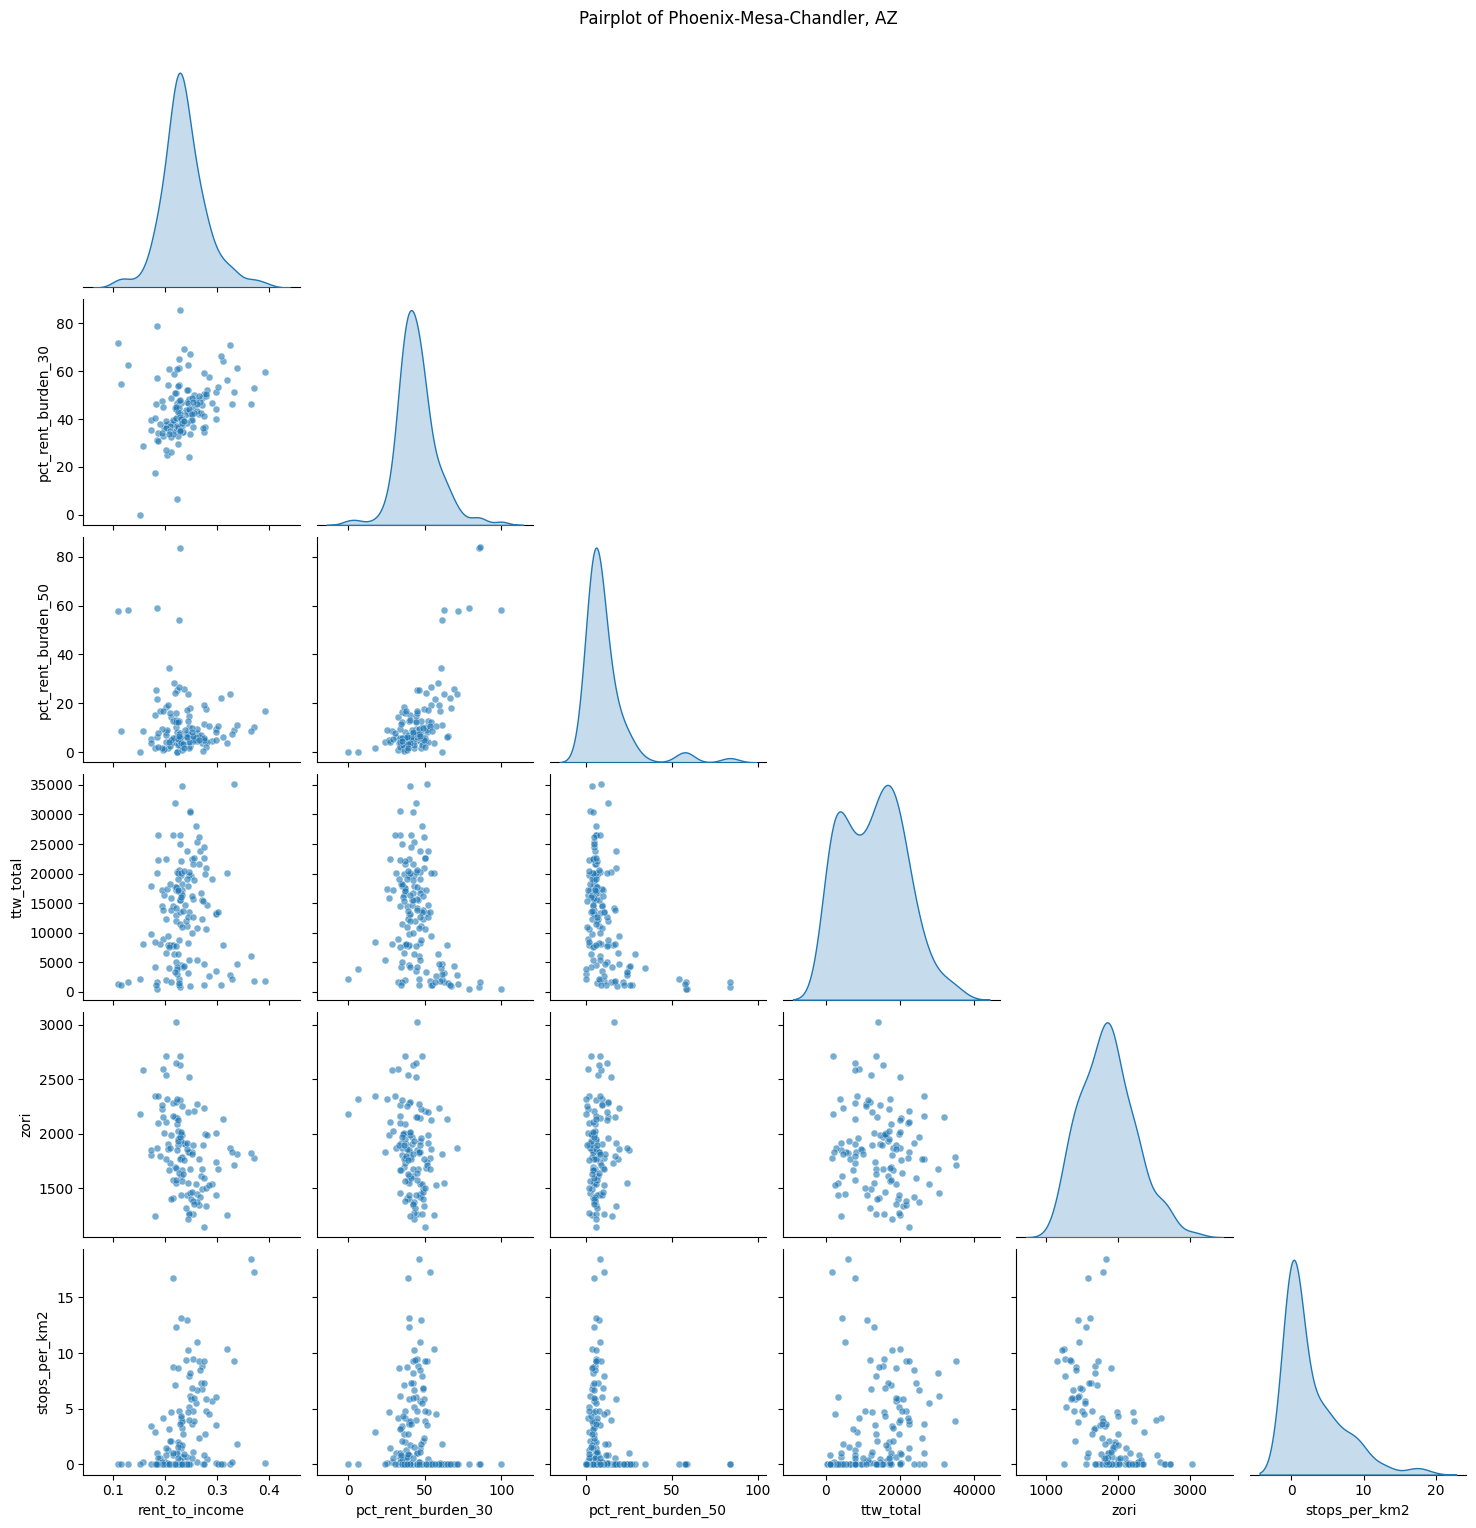

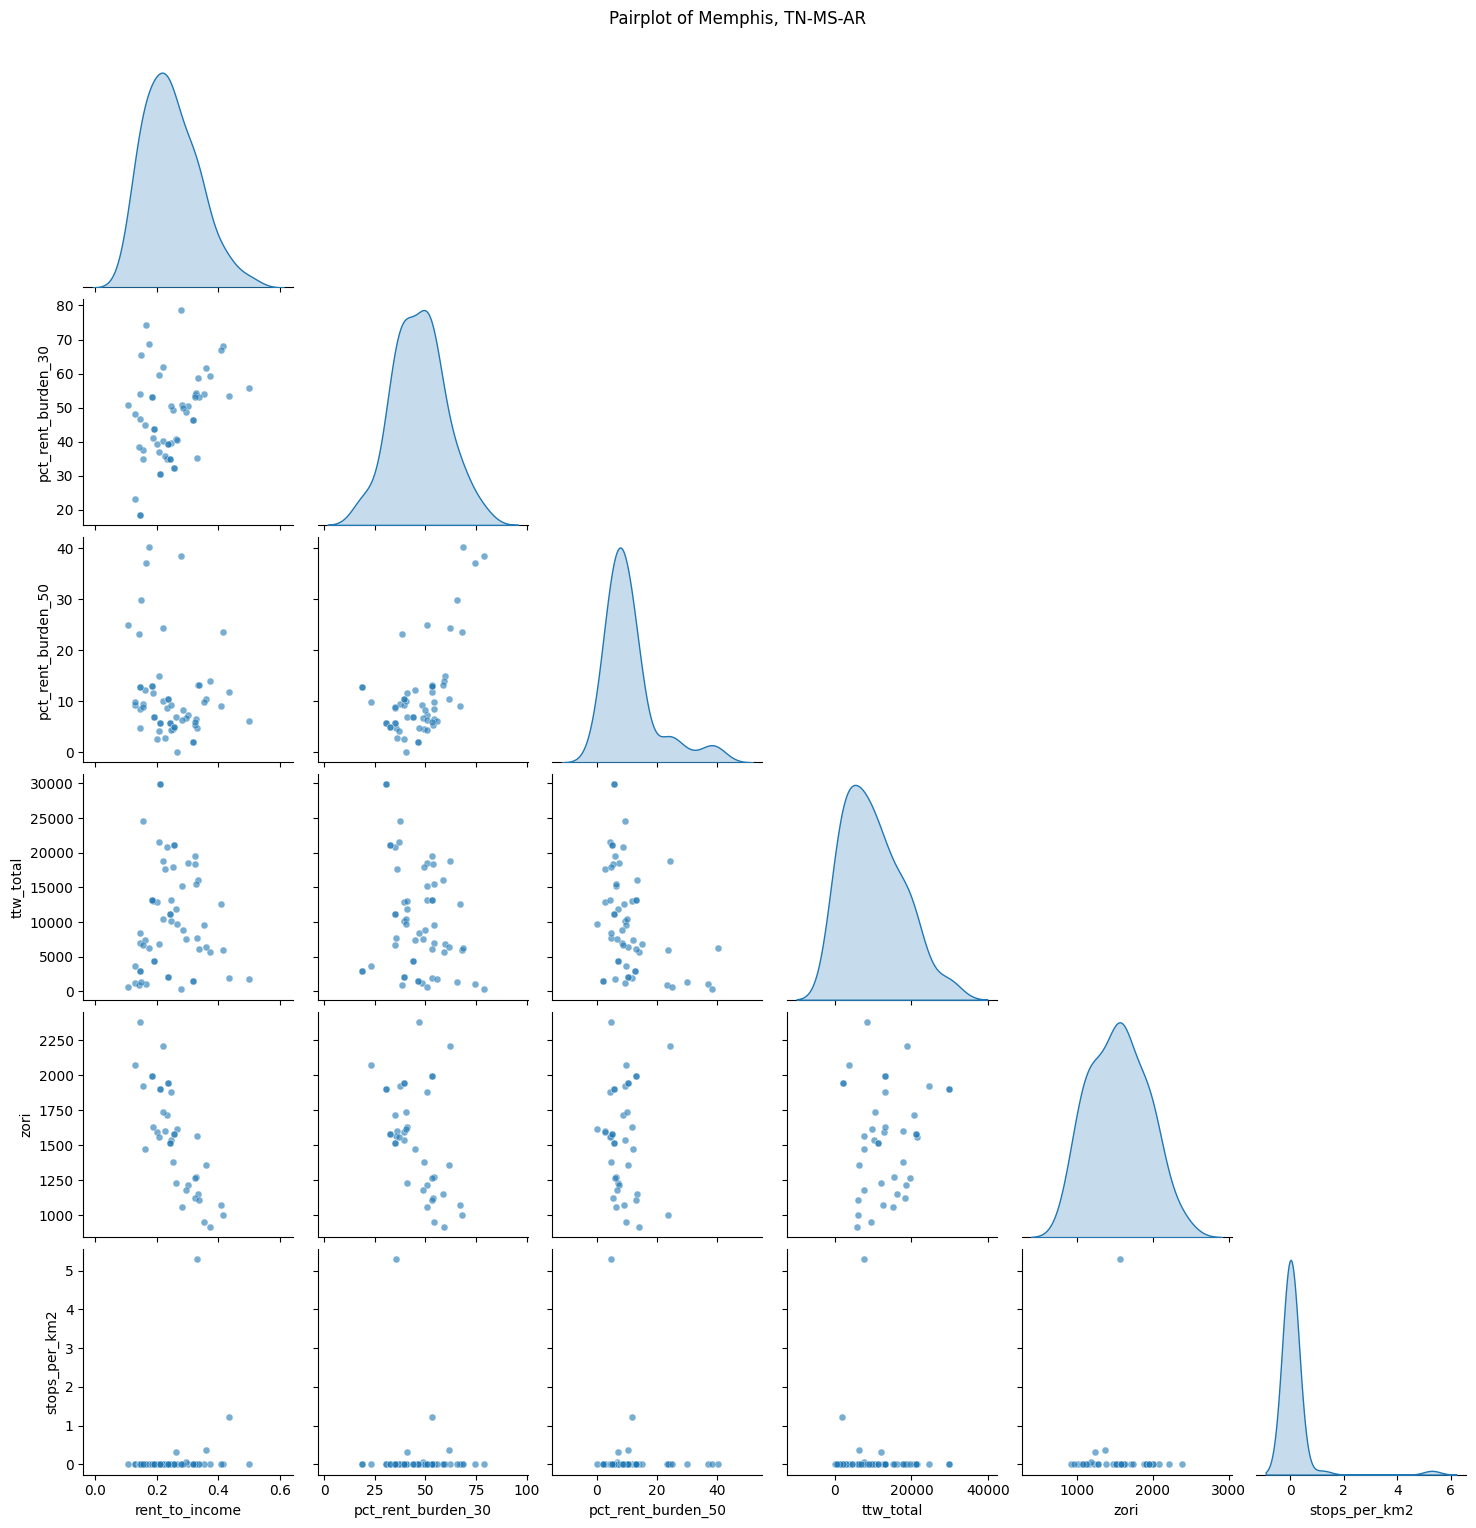

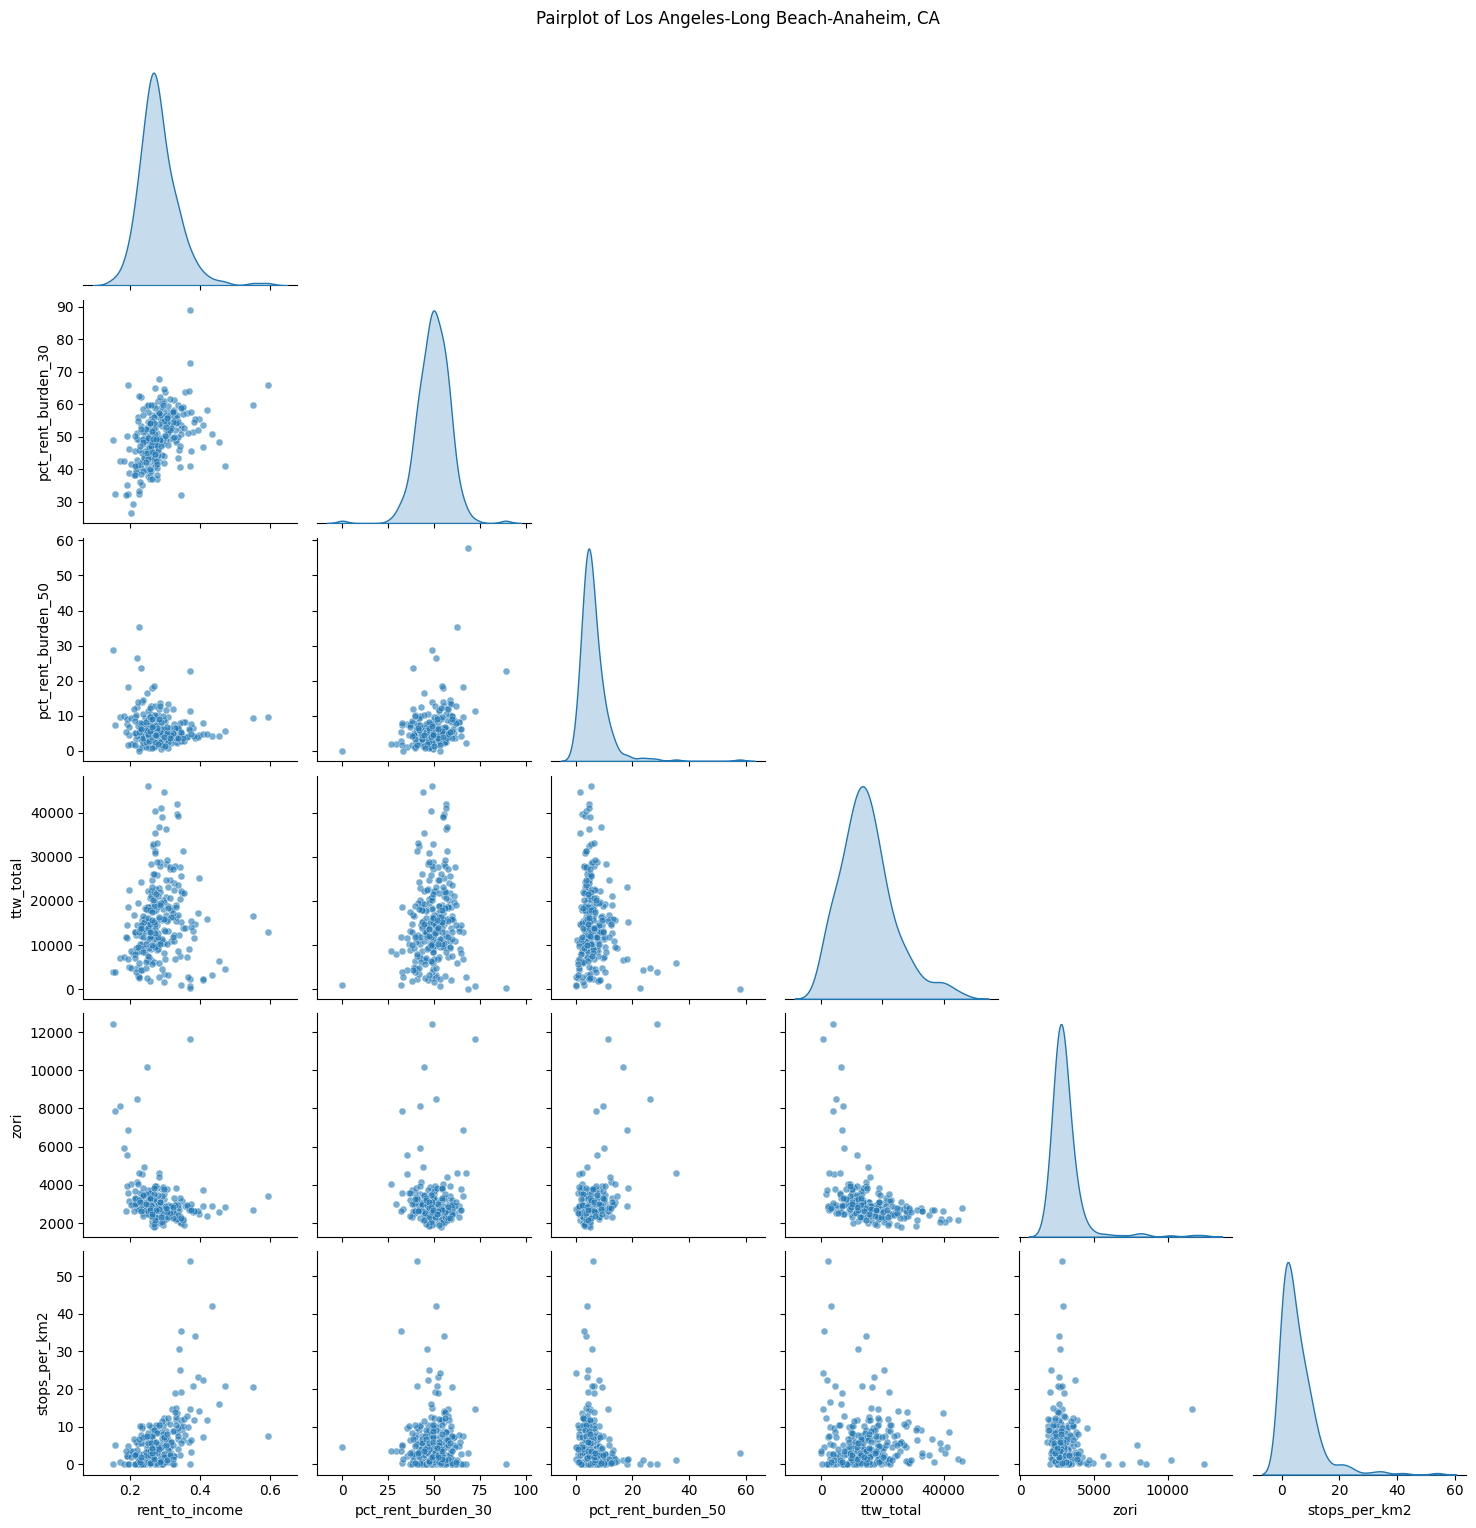

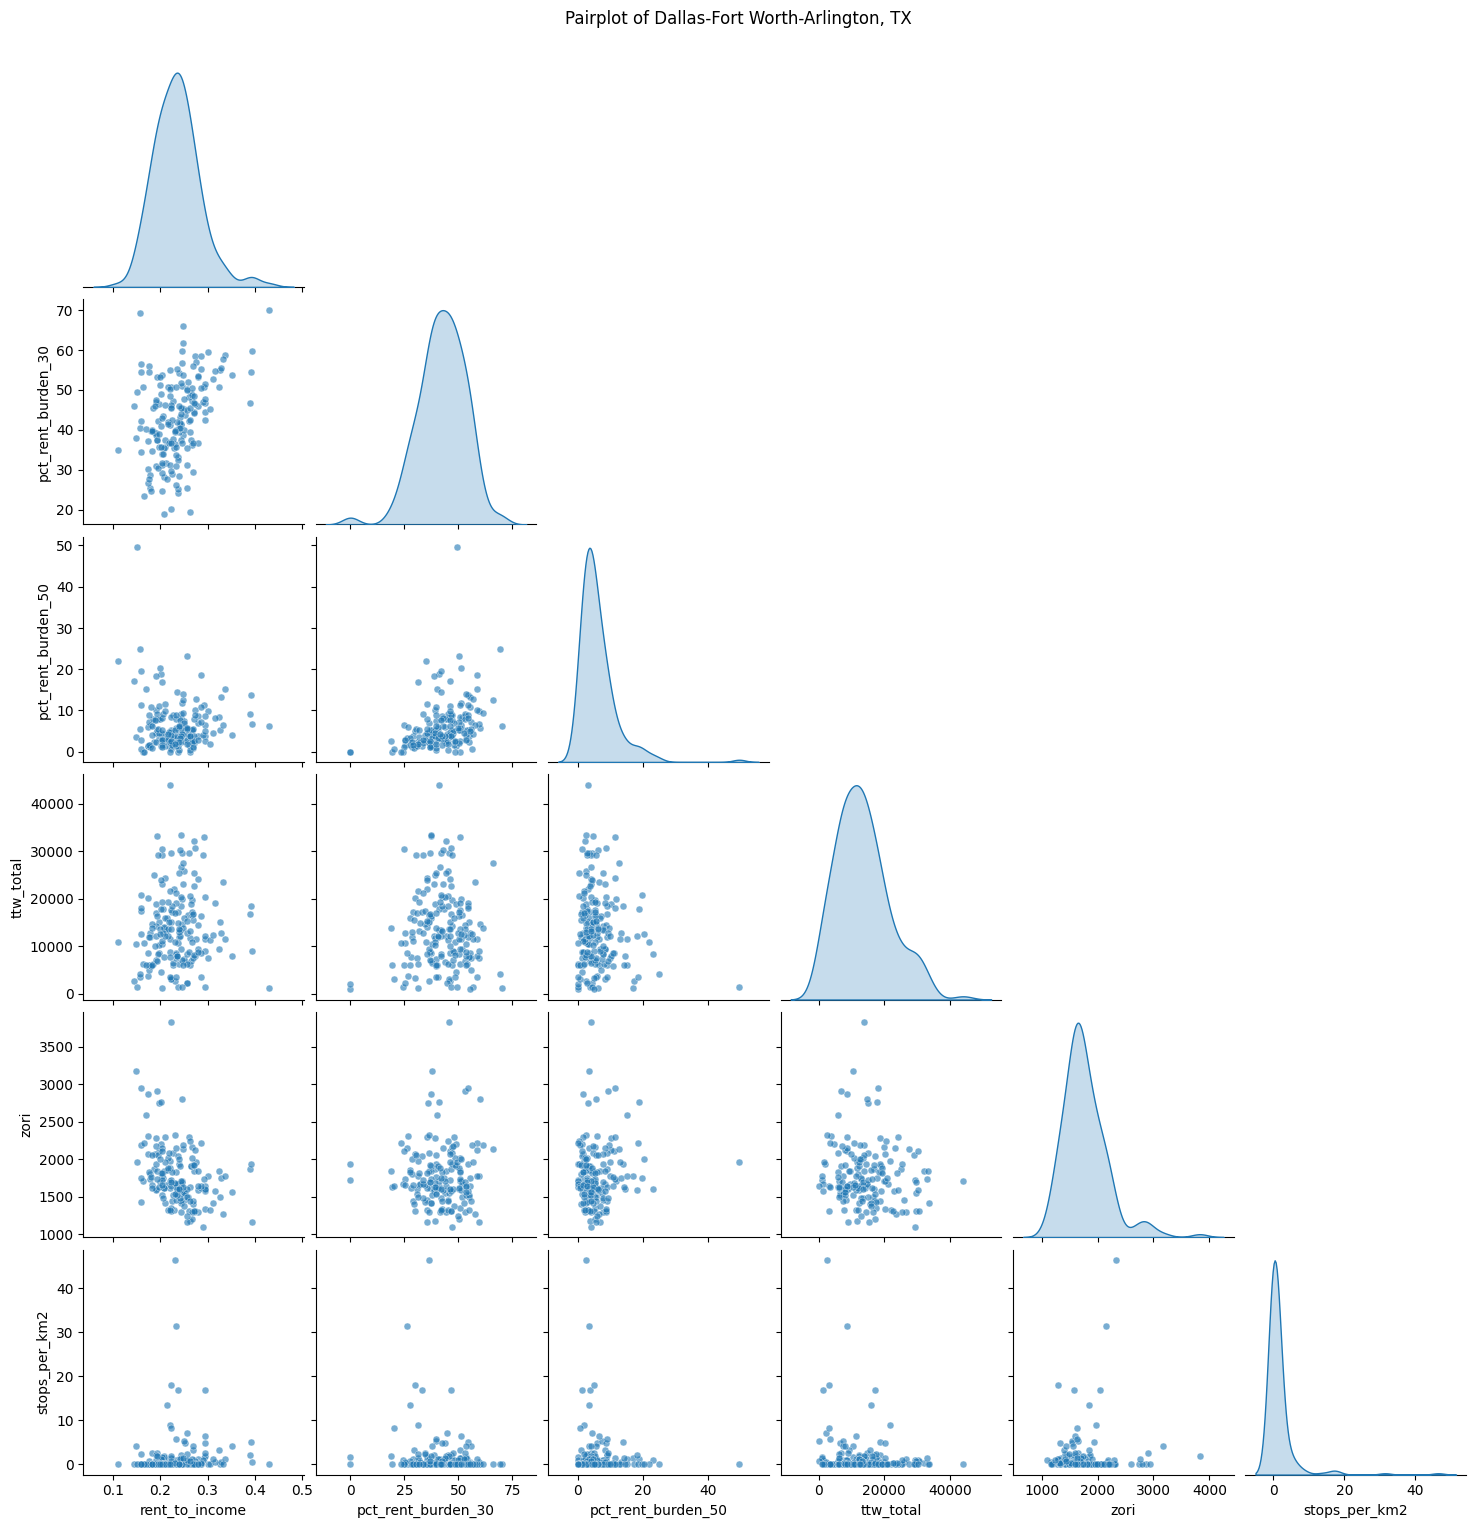

In [41]:
#I think profile is a great starting off point for the EDA. Youll have to literally stop me to not continue.
#Analysis per metro
cols = ["rent_to_income","pct_rent_burden_30", "pct_rent_burden_50","ttw_total","zori","stops_per_km2"]

for metro in df["metro_name"].unique():
    subset = df[df["metro_name"] == metro]

    g = sns.pairplot(
        subset[cols],
        diag_kind="kde",
        corner=True,
        plot_kws={"alpha":0.6, "s":25}
    )
    g.fig.suptitle(f"Pairplot of {metro}", y=1.02)
    plt.show()


Graphs indicate that standardization may be necessary to ensure the comparisons between these two metros are on equal footing and truly meaningful

## Preliminary Analysis: Metro and Racial Majority Comparisons

This figure represents the rent burden by race. The rent to income ratio can generalize how much of a tenants gross income would be allocated to rental costs. One can analyze that most races observe 30% rent to income. In markets where any given race is more than 40%, there exists more variability in rent to income. The race with the highest rent burden appears to be Black Americans as there is a visual positive correlation. Hispanics are also observed to have a positive correlation of rent burden as the prospective population increases.Caucasians are observed with a lower rent burden, as there is a negative correlation as the population percentage increases.  The most variability of rent burden exists in "Other" races, as most of the population is concentrated at less than 15% of the population.

In [42]:

def race_vs_rent_plot(df, metro_name):
    race_cols = ["pct_black", "pct_hispanic", "pct_white", "pct_asian", "pct_other"]
    titles = [
        "% Black vs Rent Burden",
        "% Hispanic vs Rent Burden",
        "% White vs Rent Burden",
        "% Asian vs Rent Burden",
        "% Other Race vs Rent Burden"
    ]
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))
    axes = axes.flatten()

    for i, col in enumerate(race_cols):
        ax = axes[i]
        
        #Scatter
        sns.scatterplot(data=df, x=col, y="rent_to_income", alpha=0.6, ax=ax)
        
        #Fit regression
        x = df[col].values.reshape(-1, 1)
        y = df["rent_to_income"].values
        
        if df[col].notna().sum() > 1:  # avoid errors with empty cols
            model = LinearRegression().fit(x, y)
            y_pred = model.predict(x)
            r2 = r2_score(y, y_pred)
            
            #Plot regression line
            sns.regplot(data=df, x=col, y="rent_to_income",
                        scatter=False, ci=False, ax=ax, color="red")
            
            #show R squared
            ax.text(0.05, 0.85, f"R² = {r2:.2f}",
                    transform=ax.transAxes, fontsize=12,
                    bbox=dict(facecolor='white', alpha=0.6))
        
        ax.set_title(titles[i])

    # remove last empty subplot
    axes[-1].axis("off")

    plt.suptitle(f"{metro_name.capitalize()}: Race % vs Rent Burden", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

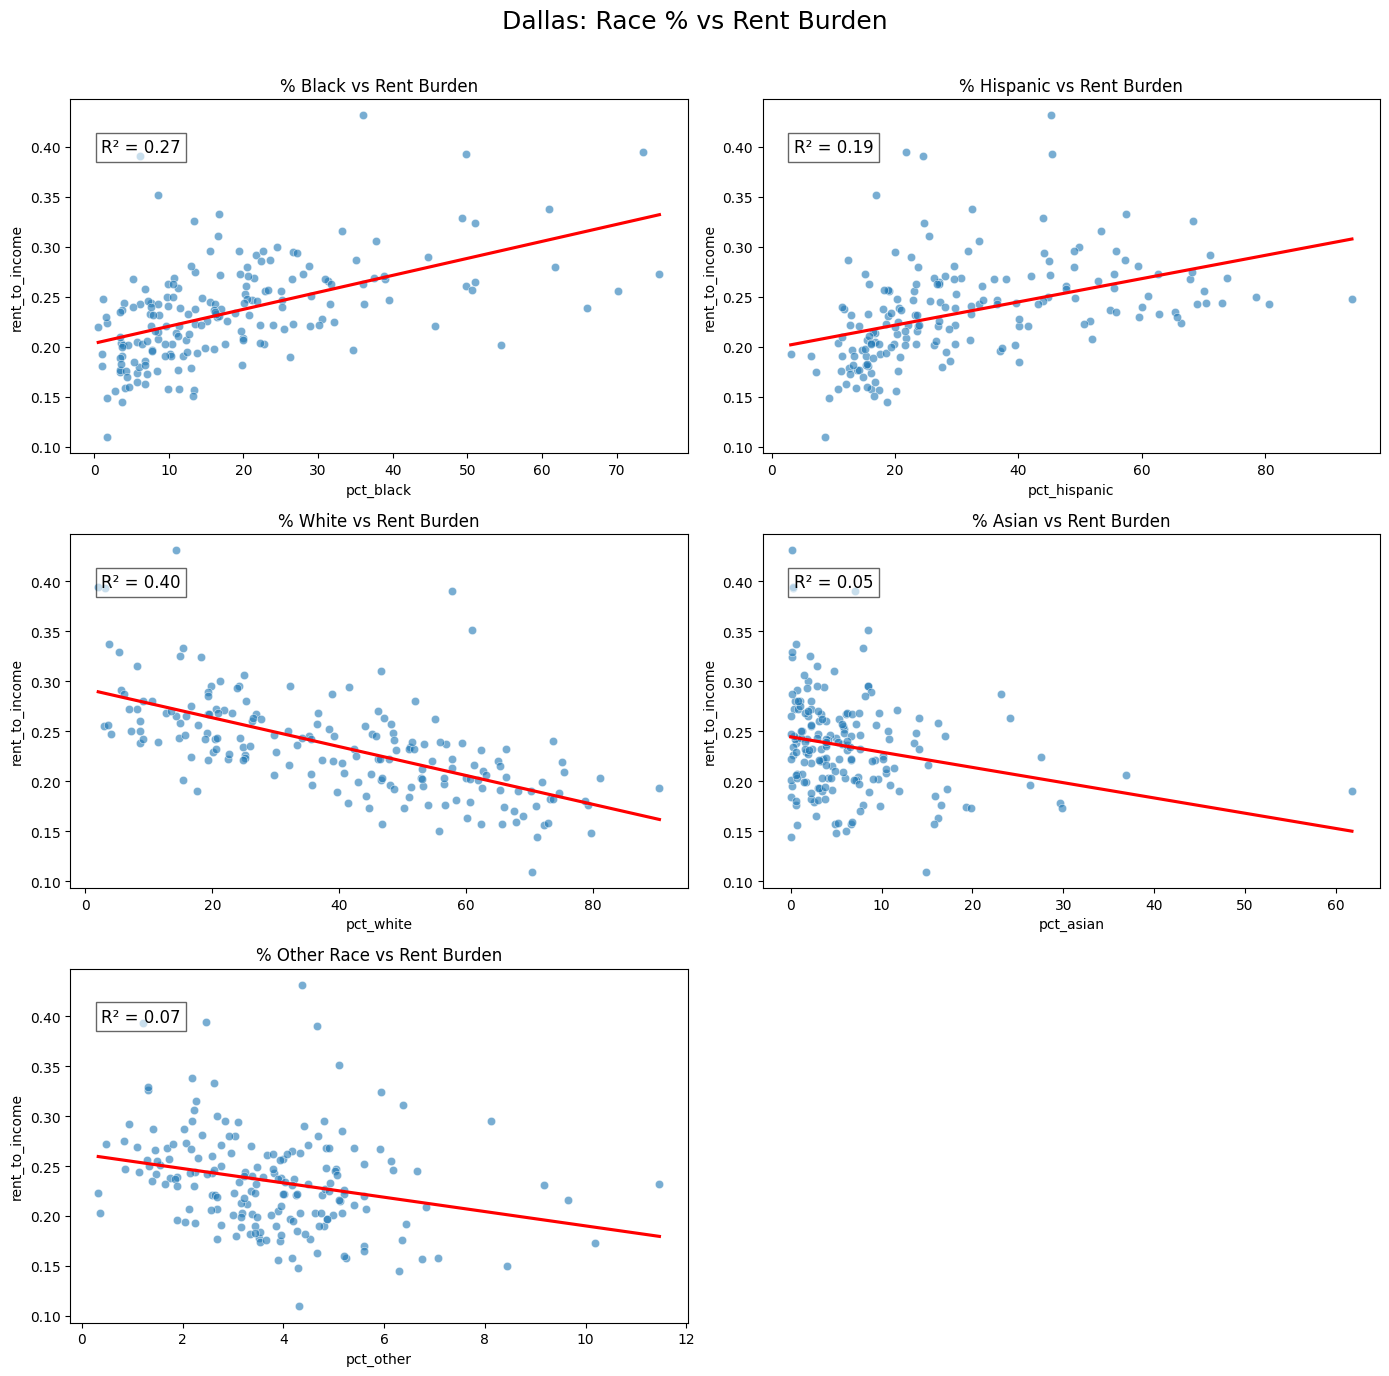

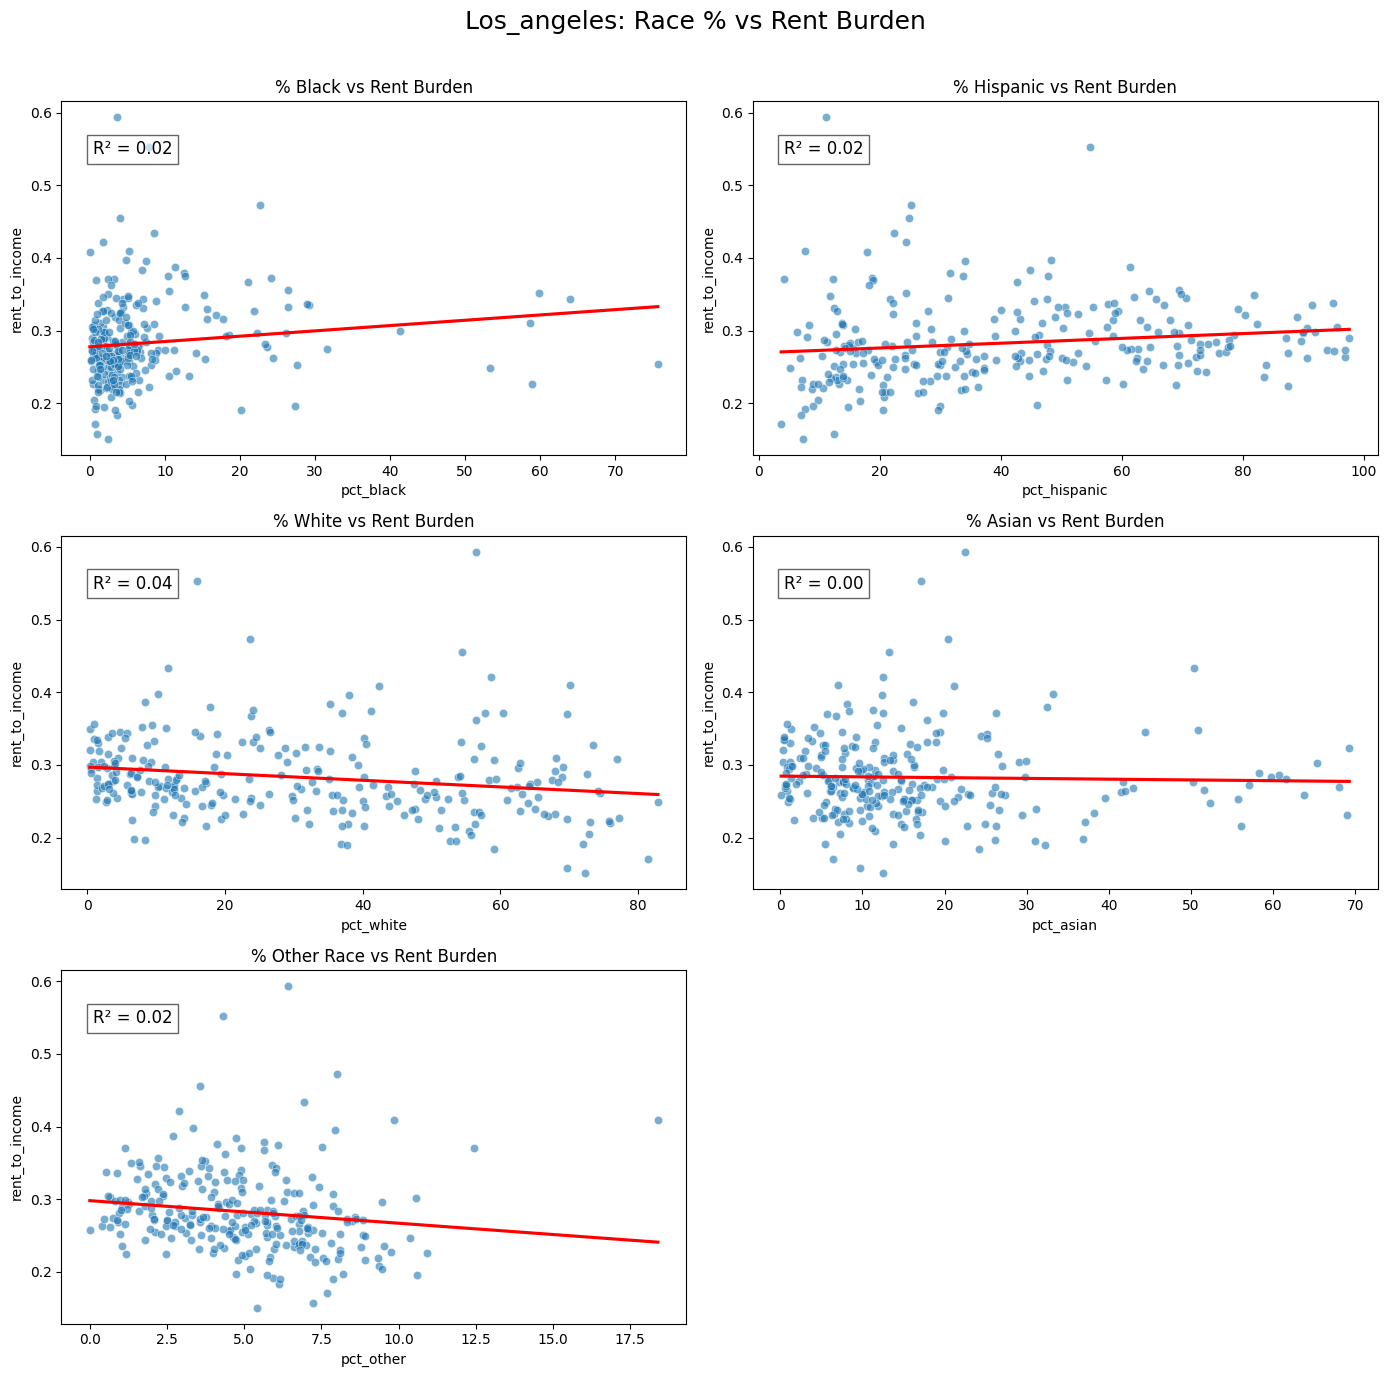

In [43]:
race_vs_rent_plot(results["dallas"]["df"], "dallas")
race_vs_rent_plot(results["los_angeles"]["df"], "los_angeles")


Within the minorities, rent to income tends to increase as the percent of the minority increase within the metro. However, we see that there is a different response within each Metro. 

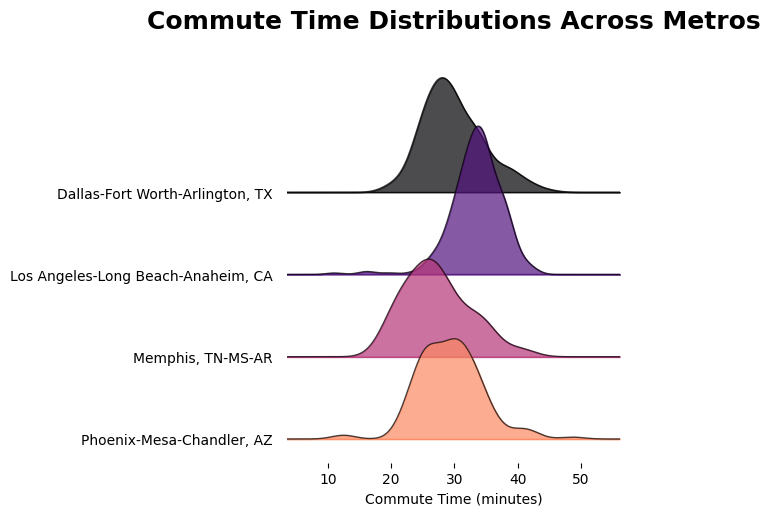

In [13]:
joypy.joyplot(
    df,
    by="metro_name",#group by metro name    
    column="commute_min_proxy",          
    kind="kde",                         
    overlap=1.4,                       
    linewidth=1,
    alpha=0.7,
    colormap=plt.cm.magma              
)



plt.title("Commute Time Distributions Across Metros", fontsize=18, weight="bold")
plt.xlabel("Commute Time (minutes)", fontsize=10)
plt.ylabel("Metro", fontsize=14)
plt.show()

This figure demonstrates the distribution of commute time segmented by easch prospective metropolitan area. One can observe prevalent commute time of between 30 and 45 minutes in the LA area. The other metropolitan areas: Dallas- Fort Worth, Memphis, and Phoenix-Mesa-Chandler experience commute times between 15 to 45 areas. There appears to be bimodal distribution times experienced within DFW and Memphis- whereas the Phoenix area experiences a trimodal distribution with notable commute times between 20 to 30 minutes, 30 and 40 minutes and over 40 minutes.

## Spatial Analysis

In Part 1, we explored the significance of our features and how they contributed to rent burden and commute time. For this next part of our analysis we analyze and accomplish two things: equitable shares among demographic ZCTAs and spatial topology influence. 

In [14]:
zcta_path= r"C:\Users\Owner\Documents\GitHub\DAT490\DAT490\tl_2024_us_zcta520.shp"

In [15]:
#Read ZCTA shapefilecta = gpd.read_file(zcta_path)
zcta = gpd.read_file(zcta_path)
# Inspect column names to find the ZCTA code column
zcta.columns


Index(['ZCTA5CE20', 'GEOID20', 'GEOIDFQ20', 'CLASSFP20', 'MTFCC20',
       'FUNCSTAT20', 'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20',
       'geometry'],
      dtype='object')

In [16]:
# 1. Make both ZCTA columns clean 5-digit strings

zcta["ZCTA5CE20"] = (
    zcta["ZCTA5CE20"]
    .astype(str)
    .str.extract(r"(\d{5})", expand=False)
    .str.zfill(5)
)

df["ZCTA5CE"] = (
    df["ZCTA5CE"]
    .astype(str)
    .str.extract(r"(\d{5})", expand=False)
    .str.zfill(5)
)

# 2. Merge
gdf = zcta.merge(df, left_on="ZCTA5CE20", right_on="ZCTA5CE", how="inner")



# 3. confirm it's a GeoDataFrame with geometry
type(gdf), gdf.columns

(geopandas.geodataframe.GeoDataFrame,
 Index(['ZCTA5CE20', 'GEOID20', 'GEOIDFQ20', 'CLASSFP20', 'MTFCC20',
        'FUNCSTAT20', 'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20',
        'geometry', 'ZCTA5CE', 'rent_to_income', 'pct_rent_burden_30',
        'pct_rent_burden_50', 'zori', 'commute_min_proxy', 'pct_commute_lt10',
        'pct_commute_10_19', 'pct_commute_20_29', 'pct_commute_30_44',
        'pct_commute_45_59', 'pct_commute_60_plus', 'ttw_total',
        'pct_drive_alone', 'pct_carpool', 'pct_car', 'pct_transit', 'pct_walk',
        'pct_wfh', 'total_pop', 'pct_white', 'pct_black', 'pct_asian',
        'pct_hispanic', 'pct_other', 'median_income', 'income_segment',
        'stops_per_km2', 'period', 'metro_key', 'metro_name'],
       dtype='object'))

<Axes: >

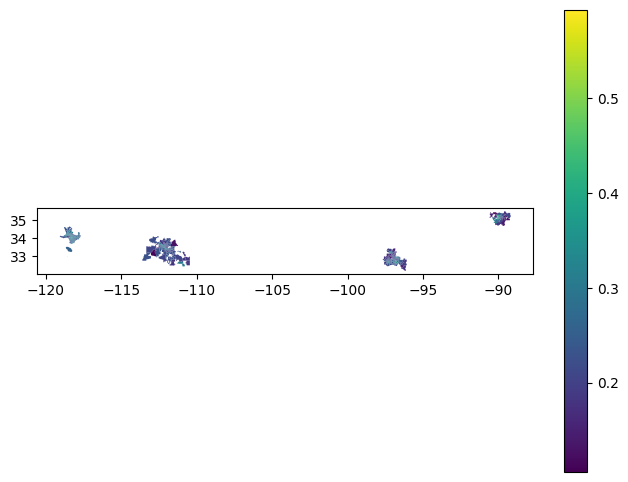

In [17]:
#sanity check
gdf.plot(column="rent_to_income", legend=True, figsize=(8,6))


This is going to show all 4 metros within our study

### Filtering to only Dallas and Los Angeles

In [18]:
#ID like to filter to the metros using the metro configs or metro_key
subset = gdf[gdf["metro_key"].isin(["dallas", "los_angeles"])]
subset


,ZCTA5CE20,GEOID20,GEOIDFQ20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,...,pct_black,pct_asian,pct_hispanic,pct_other,median_income,income_segment,stops_per_km2,period,metro_key,metro_name
155,75232,75232,860Z200US75232,B5,G6350,S,22856483,9339,+32.6589987,-096.8395931,...,49.339037,0.172296,43.932508,1.318956,5.601914e+04,Low,0.525485,2025-09-30,dallas,"Dallas-Fort Worth-Arlington, TX"
156,75036,75036,860Z200US75036,B5,G6350,S,28071673,8750232,+33.1333512,-096.9146625,...,7.687887,26.351243,13.060671,4.860105,1.485747e+05,High,0.000000,2025-09-30,dallas,"Dallas-Fort Worth-Arlington, TX"
157,75141,75141,860Z200US75141,B5,G6350,S,30273359,2018582,+32.6399768,-096.6932838,...,35.966087,0.163617,45.292280,4.373048,4.525000e+04,Low,0.131383,NaT,dallas,"Dallas-Fort Worth-Arlington, TX"
158,75063,75063,860Z200US75063,B5,G6350,S,52393269,329301,+32.9106274,-097.0004814,...,10.333983,61.764499,6.449644,3.846786,1.341609e+05,High,0.173314,2025-09-30,dallas,"Dallas-Fort Worth-Arlington, TX"
159,75038,75038,860Z200US75038,B5,G6350,S,19782729,104199,+32.8722599,-096.9788098,...,32.144904,27.517872,20.408409,3.351130,7.604733e+04,Medium,1.167294,2025-09-30,dallas,"Dallas-Fort Worth-Arlington, TX"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,90815,90815,860Z200US90815,B5,G6350,S,18269698,512747,+33.7950672,-118.1157237,...,6.840732,12.600058,24.165533,6.033579,-3.331812e+07,Low,7.554878,2025-09-30,los_angeles,"Los Angeles-Long Beach-Anaheim, CA"
611,90046,90046,860Z200US90046,B5,G6350,S,14674077,3009,+34.1078099,-118.3622474,...,5.215406,7.201670,15.613049,6.682666,1.073359e+05,Medium,3.680837,2025-09-30,los_angeles,"Los Angeles-Long Beach-Anaheim, CA"
612,90503,90503,860Z200US90503,B5,G6350,S,13640983,4355,+33.8394633,-118.3536989,...,3.767283,41.734019,15.138156,6.782001,1.251239e+05,High,2.622270,2025-09-30,los_angeles,"Los Angeles-Long Beach-Anaheim, CA"
613,90278,90278,860Z200US90278,B5,G6350,S,9507745,0,+33.8736054,-118.3702644,...,1.935096,20.038462,14.778846,10.588942,1.621594e+05,High,4.845360,2025-09-30,los_angeles,"Los Angeles-Long Beach-Anaheim, CA"


In [19]:
dallas_gdf = gdf[gdf["metro_key"] == "dallas"]
la_gdf = gdf[gdf["metro_key"] == "los_angeles"]



### Spatial DIstributions

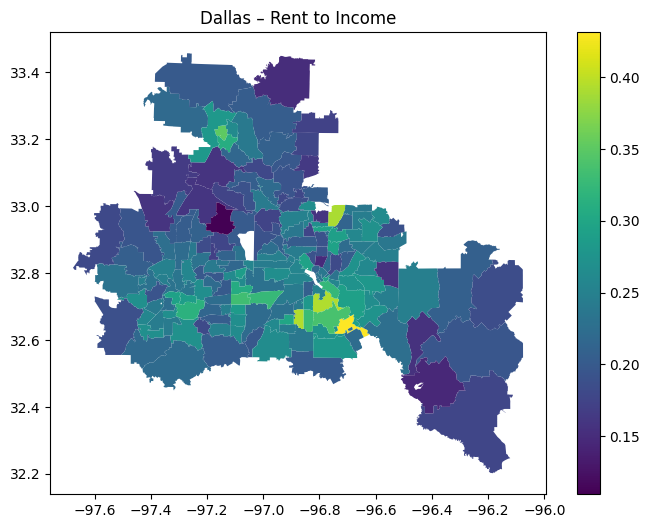

In [20]:
#plotting the filtered metros
dallas_gdf.plot(column="rent_to_income", cmap="viridis", legend=True, figsize=(8,6))
plt.title("Dallas – Rent to Income")
plt.show()


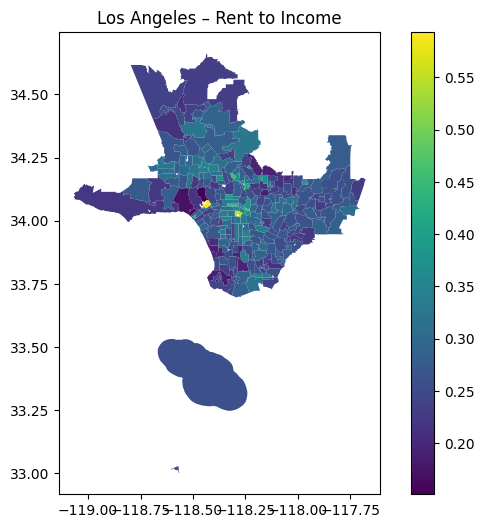

In [21]:
la_gdf.plot(column="rent_to_income", cmap="viridis", legend=True, figsize=(8,6))
plt.title("Los Angeles – Rent to Income")
plt.show()


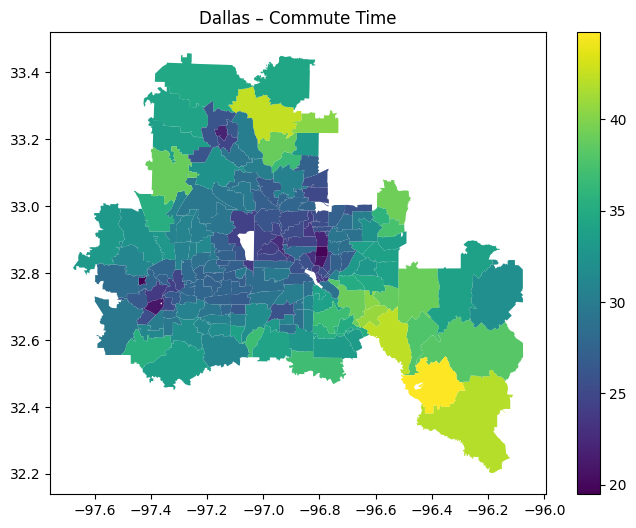

In [22]:
#take a look at commute
#plotting the filtered metros
dallas_gdf.plot(column="commute_min_proxy", cmap="viridis", legend=True, figsize=(8,6))
plt.title("Dallas – Commute Time")
plt.show()

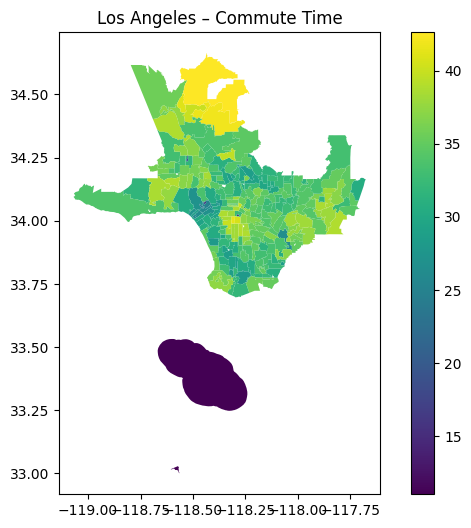

In [23]:
la_gdf.plot(column="commute_min_proxy", cmap="viridis", legend=True, figsize=(8,6))
plt.title("Los Angeles – Commute Time")
plt.show()


## Cluster Analysis

For our cluster analysis, we will be evaluating whole racial composisition per ZCTA- we will not be segmenting by racial majority to create equitable representation. Essential to clustering, data preprossing begins through standardization. Using the Silouette score and the Elbow method in tandem to land on the most robust k value, we begin our clustering by running a kmeans analysis. 

In [24]:
# metros we care about
metros1 = ["dallas", "los_angeles"]

# features used to define clusters (structure, not race)
#later these will be scaled because scaling is necessary when we talk about distances and Kmeans
cluster_features = [
    "rent_to_income",
    "commute_min_proxy",
    "stops_per_km2",
    "pct_car",
    "median_income"
]

# race columns used only for *describing* clusters
race_cols = ["pct_white","pct_black","pct_asian","pct_hispanic","pct_other"]


In [25]:
def run_kmeans_for_metro(df, metro_key, k_range=range(2,9), k_chosen=4):
    """
    df: full attribute dataframe
    metro_key: e.g. "dallas" or "los_angeles"
    k_range: range of k values to try for elbow/silhouette
    k_chosen: final k to fit for this metro
    """

    #subset to one metro
    df_m = df[df["metro_key"] == metro_key].copy()

    #drop rows with any missing cluster feature values
    df_m_clean = df_m.dropna(subset=cluster_features).copy()

    #scale cluster features
    X = df_m_clean[cluster_features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    #elbow method
    clusters = list(k_range)
    meanDistortions = []

    for k in clusters:
        model = KMeans(n_clusters=k, random_state=42, n_init="auto")
        model.fit(X_scaled)
        distortion = (
            np.sum(np.min(cdist(X_scaled, model.cluster_centers_, "euclidean"), axis=1))
            / X_scaled.shape[0]
        )
        meanDistortions.append(distortion)
        print(f"[{metro_key}] k={k}  Avg Distortion={distortion:.4f}")

    plt.figure(figsize=(7,4))
    plt.plot(clusters, meanDistortions, "bx-")
    plt.xlabel("k"); plt.ylabel("Average Distortion")
    plt.title(f"Elbow Method — {metro_key}")
    plt.show()

    #silhouette scores
    sil_scores = []
    for k in clusters:
        if k == 1:
            sil_scores.append(np.nan)
            continue
        model = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = model.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)
        print(f"[{metro_key}] k={k}  Silhouette={score:.4f}")

    plt.figure(figsize=(7,4))
    plt.plot(clusters, sil_scores, "bo-")
    plt.xlabel("k"); plt.ylabel("Silhouette Score")
    plt.title(f"Silhouette Analysis — {metro_key}")
    plt.show()

    #fit final model with chosen k
    print(f"\nFitting final KMeans for {metro_key} with k={k_chosen}")
    kmeans = KMeans(n_clusters=k_chosen, random_state=42, n_init="auto")
    labels_final = kmeans.fit_predict(X_scaled)

    #attach cluster labels to cleaned metro dataframe
    df_m_clean["cluster"] = labels_final.astype(int)

    return df_m_clean, scaler, kmeans

Running KMeans for dallas
[dallas] k=2  Avg Distortion=1.6223
[dallas] k=3  Avg Distortion=1.4911
[dallas] k=4  Avg Distortion=1.3364
[dallas] k=5  Avg Distortion=1.2429
[dallas] k=6  Avg Distortion=1.1950
[dallas] k=7  Avg Distortion=1.1389
[dallas] k=8  Avg Distortion=1.1326


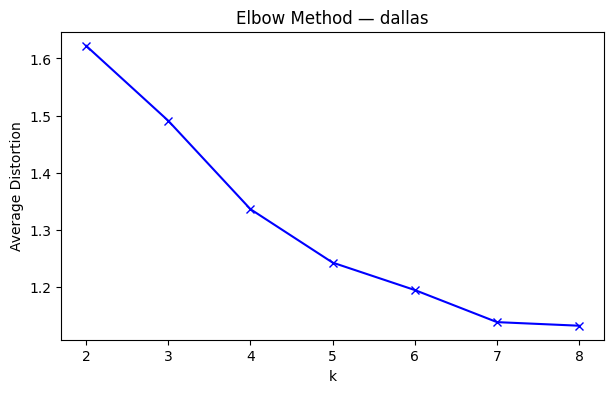

[dallas] k=2  Silhouette=0.2592
[dallas] k=3  Silhouette=0.3108
[dallas] k=4  Silhouette=0.2750
[dallas] k=5  Silhouette=0.2385
[dallas] k=6  Silhouette=0.2272
[dallas] k=7  Silhouette=0.2320
[dallas] k=8  Silhouette=0.1987


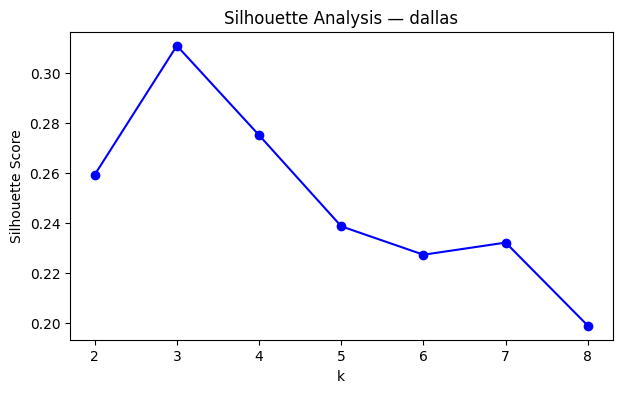


Fitting final KMeans for dallas with k=4
Running KMeans for los_angeles
[los_angeles] k=2  Avg Distortion=1.5724
[los_angeles] k=3  Avg Distortion=1.5465
[los_angeles] k=4  Avg Distortion=1.5190
[los_angeles] k=5  Avg Distortion=1.3275
[los_angeles] k=6  Avg Distortion=1.3031
[los_angeles] k=7  Avg Distortion=1.2195
[los_angeles] k=8  Avg Distortion=1.0815


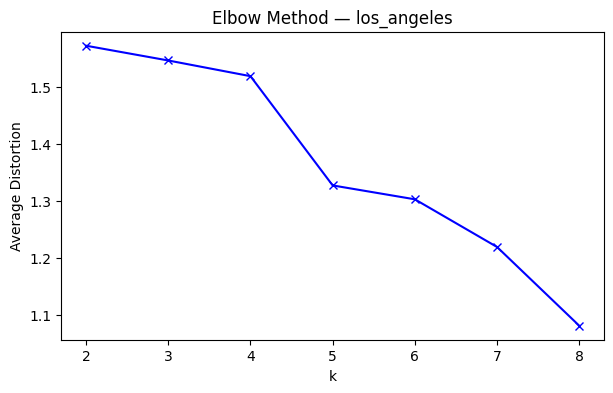

[los_angeles] k=2  Silhouette=0.4503
[los_angeles] k=3  Silhouette=0.5322
[los_angeles] k=4  Silhouette=0.5352
[los_angeles] k=5  Silhouette=0.2691
[los_angeles] k=6  Silhouette=0.2644
[los_angeles] k=7  Silhouette=0.2087
[los_angeles] k=8  Silhouette=0.2349


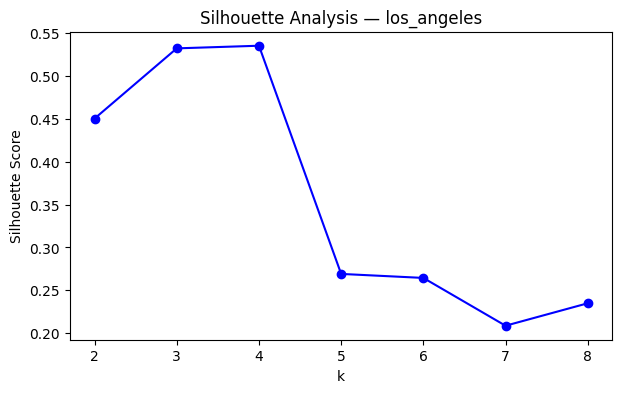


Fitting final KMeans for los_angeles with k=5


In [26]:
results = {}

#choose k per metro 
#k can be cahnged
k_choices = {
    "dallas": 4, #hardcoded
    "los_angeles": 5 #hardcoded
}

for metro in metros1:
    print("="*60)
    print(f"Running KMeans for {metro}")
    df_m_clean, scaler_m, kmeans_m = run_kmeans_for_metro(
        df=df,
        metro_key=metro,
        k_range=range(2,9),
        k_chosen=k_choices[metro]
    )
    results[metro] = {
        "df": df_m_clean,
        "scaler": scaler_m,
        "kmeans": kmeans_m
    }


For our cluster analysis, we establish **k=4** for Dallas and **k=5** for Los Angeles


Cluster centers for dallas


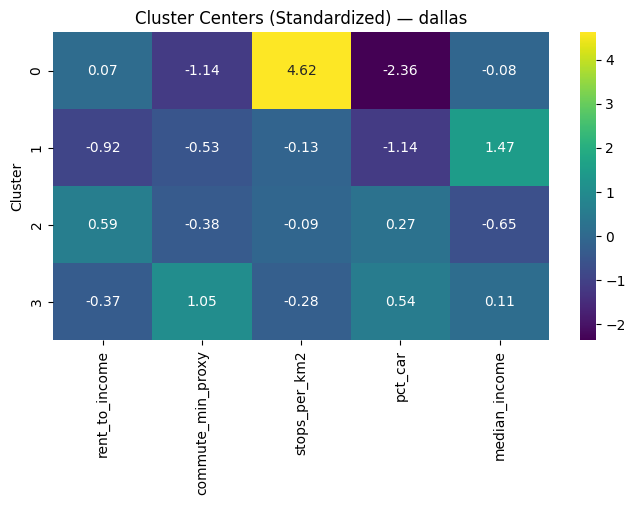


Cluster centers for los_angeles


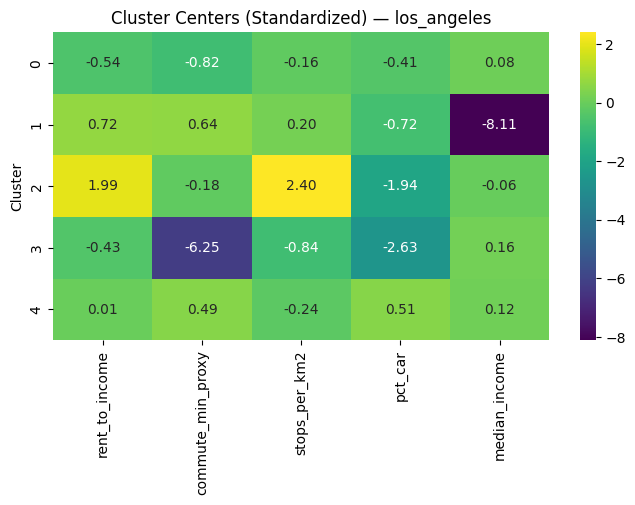

In [27]:
#Cluster Correlations for features- separated by metro1 metros
#La=5; Dallas=4
#loop to go through each metro in metro1
for metro in metros1:
    print(f"\nCluster centers for {metro}")
    kmeans_m = results[metro]["kmeans"]

    centers = pd.DataFrame(
        kmeans_m.cluster_centers_,
        columns=cluster_features
    )

    plt.figure(figsize=(8,4))
    sns.heatmap(centers, annot=True, cmap="viridis", fmt=".2f")
    plt.title(f"Cluster Centers (Standardized) — {metro}")
    plt.ylabel("Cluster")
    plt.show()


How these correlations can be interpreted:

* Standardized centers help identify which groups may face transit and affordability challenges
  
* Higher standardized rent_to_income means more rent-burdened

* Higher standardized commute_min_proxy means longer average commute etc. <br>

This is going to show which clusters are going to have ta high rent burden, high commute time, high median income, high car dependency, and a high transit density. Positive is going to mean above metro average where negative is going to be below metro average. <br>

**Key Takeaways:**
* Dallas clusters show different commuting and job density patterns but Cluster 0 tends to have a high job density, low car usage, and low commute time
* Dallas clusters are shaped by car reiance and dependence suggesting car acess doesn't guarantee affordability
* In Dallas, lower affordability doesn't correlate with long commutes
* Los Angeles shows more extreme variation especially when it comes to income and car relaince
* Los Angeles Cluster 4 suggests a highly car dependent cluster with a low income group
* Los Angeles’ transit and affordability is strongly stratified
* In Los Angeles access to transit doesn’t guarantee low-income groups from rent burden as  incomes and rent  increase near transit rich areas




### Digging Deeper to See How Race is Compositioned Within Each Cluster

Race composition by cluster — dallas


,pct_white,pct_black,pct_asian,pct_hispanic,pct_other
cluster,,,,,
0,50.899849,16.911538,6.873136,19.845314,5.470163
1,60.089100,7.376205,13.452574,14.910799,4.171323
2,28.786412,22.055048,4.773990,40.946332,3.438219
3,43.846313,20.024236,4.334688,27.937450,3.857313


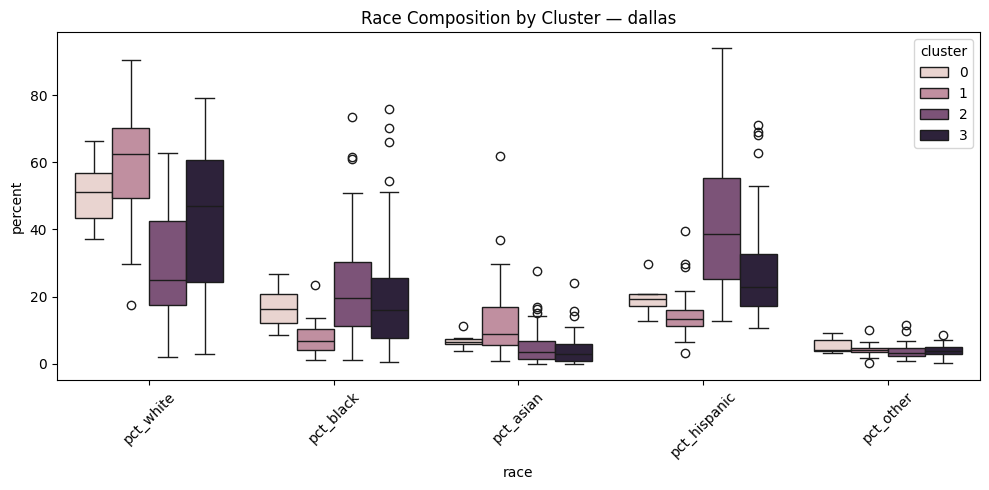

Race composition by cluster — los_angeles


,pct_white,pct_black,pct_asian,pct_hispanic,pct_other
cluster,,,,,
0,45.546817,4.891511,16.489347,26.822851,6.249474
1,28.972229,10.102271,16.768834,38.190699,5.965967
2,30.085687,7.569793,21.704431,35.552179,5.087910
3,35.543278,0.153468,0.122775,64.180479,0.000000
4,23.549143,8.353724,15.027498,48.939662,4.129973


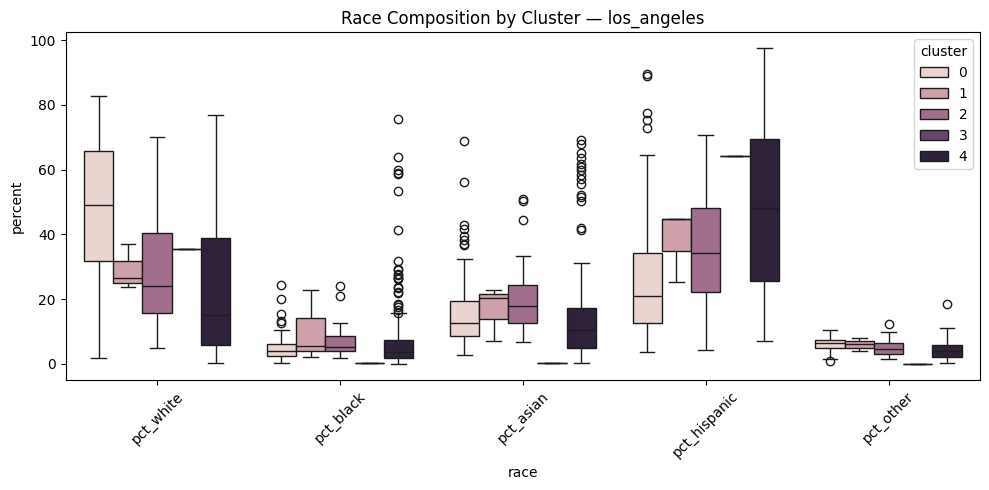

In [28]:
for metro in metros1:
    print("="*60)
    print(f"Race composition by cluster — {metro}")
    df_m = results[metro]["df"]

    #ensure race cols are numeric
    df_m[race_cols] = df_m[race_cols].apply(pd.to_numeric, errors="coerce")

    #table: mean race % per cluster using grroupby functions
    cluster_race_summary = df_m.groupby("cluster")[race_cols].mean()
    display(cluster_race_summary)

    #boxplots of race % per cluster
    plt.figure(figsize=(10,5))
    df_long = df_m.melt(id_vars="cluster", value_vars=race_cols,var_name="race", value_name="percent")
    sns.boxplot(data=df_long, x="race", y="percent", hue="cluster")
    plt.title(f"Race Composition by Cluster — {metro}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**Key Takeaways for Dallas:**<br>
* Dallas exhibits a moderate racial mixing among clusters
* Cluster 0 and Cluster 1 have high shares of White residents, Cluster 3 has the highest Black share, and Cluster 2 has the highest Hispanic share. There isn’t a cluster with a strong Black presence.


**Key Takeaways for Los Angeles:** <br>
* LA clusters show much stronger racial stratification
* Cluster 4 is largely Hispanic, Cluster 0 has the highest White concentration, Cluster 3 has the highest Black share, and Cluster 2 has the highest Asian proportions. The Asian population is low among other clusters but still  present.



Mapping clusters for dallas


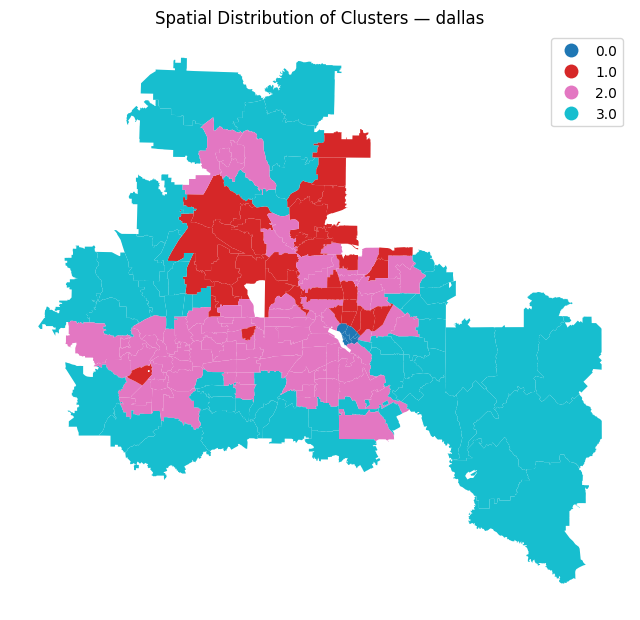


Mapping clusters for los_angeles


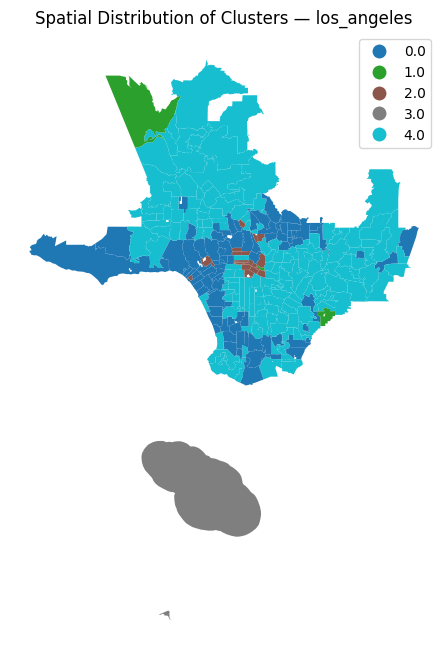

In [29]:

for metro in metros1:
    print(f"\nMapping clusters for {metro}")
    
    # 1. get the attributes (with clusters) for this metro
    df_m = results[metro]["df"].copy()
    
    # make sure the standardized key exists
    if "ZCTA5_str" not in df_m.columns:
        df_m["ZCTA5_str"] = (
            df_m["ZCTA5CE"]
            .astype(str)
            .str.extract(r"(\d{5})", expand=False)
            .str.zfill(5)
        )
    
    # 2. subset the geometry to this metro
    gdf_m = gdf[gdf["metro_key"] == metro].copy()
    
    # safety: ensure gdf_m has ZCTA5_str too
    if "ZCTA5_str" not in gdf_m.columns:
        gdf_m["ZCTA5_str"] = (
            gdf_m["ZCTA5CE20"]
            .astype(str)
            .str.extract(r"(\d{5})", expand=False)
            .str.zfill(5)
        )
    
    # 3. join cluster labels onto geometry
    gdf_m = gdf_m.merge(
        df_m[["ZCTA5_str", "cluster"]],
        on="ZCTA5_str",
        how="left",
        validate="1:1"  # nice safety check; remove if it errors but things are OK
    )
    
    # 4. plot clusters
    ax = gdf_m.plot(
        column="cluster",
        categorical=True,
        cmap="tab10",
        legend=True,
        figsize=(8, 8),
        edgecolor="none"
    )
    ax.set_title(f"Spatial Distribution of Clusters — {metro}")
    ax.axis("off")
    plt.show()



In [30]:

cluster_summaries = {}

for metro in metros1:  # e.g., ["dallas","los_angeles"]
    df_m = results[metro]["df"].copy()

    # numerical summary
    summary_num = df_m.groupby("cluster")[cluster_features].mean()

    # race summary
    summary_race = df_m.groupby("cluster")[race_cols].mean()

    # combined table
    summary_all = summary_num.join(summary_race)

    cluster_summaries[metro] = summary_all

cluster_summaries


{'dallas':          rent_to_income  commute_min_proxy  stops_per_km2    pct_car  \
 cluster                                                                
 0              0.238273          24.422543      23.878007  69.957896   
 1              0.189548          27.295171       0.970382  78.058608   
 2              0.264059          28.028979       1.155070  87.387873   
 3              0.216688          34.788029       0.231493  89.155845   
 
          median_income  pct_white  pct_black  pct_asian  pct_hispanic  \
 cluster                                                                 
 0         89550.265218  50.899849  16.911538   6.873136     19.845314   
 1        147035.336398  60.089100   7.376205  13.452574     14.910799   
 2         68445.848530  28.786412  22.055048   4.773990     40.946332   
 3         96365.389997  43.846313  20.024236   4.334688     27.937450   
 
          pct_other  
 cluster             
 0         5.470163  
 1         4.171323  
 2         3.438

In [31]:
def describe_clusters_for_metro(df_m, summary_table):
    """Generate natural-language descriptions per cluster for a single metro."""
    
    # metro-level medians
    med_rent = df_m["rent_to_income"].median()
    med_commute = df_m["commute_min_proxy"].median()
    med_transit = df_m["stops_per_km2"].median()
    med_income = df_m["median_income"].median()

    descriptions = []

    for cluster_id, row in summary_table.iterrows():
        desc = []

        # rent burden
        if row["rent_to_income"] > med_rent:
            desc.append("high rent burden")
        else:
            desc.append("low rent burden")

        # commute
        if row["commute_min_proxy"] > med_commute:
            desc.append("long commutes")
        else:
            desc.append("short commutes")

        # transit access
        if row["stops_per_km2"] > med_transit:
            desc.append("high transit access")
        else:
            desc.append("low transit access")

        # income
        if row["median_income"] > med_income:
            desc.append("higher income")
        else:
            desc.append("lower income")

        # race majority
        race_group = row[race_cols].idxmax().replace("pct_", "")
        desc.append(f"majority {race_group}")

        descriptions.append(", ".join(desc))

    summary_table["description"] = descriptions
    return summary_table



In [32]:
cluster_descriptions = {}

for metro in metros1:
    df_m = results[metro]["df"].copy()
    summary_table = cluster_summaries[metro].copy()

    described = describe_clusters_for_metro(df_m, summary_table)
    cluster_descriptions[metro] = described

cluster_descriptions


{'dallas':          rent_to_income  commute_min_proxy  stops_per_km2    pct_car  \
 cluster                                                                
 0              0.238273          24.422543      23.878007  69.957896   
 1              0.189548          27.295171       0.970382  78.058608   
 2              0.264059          28.028979       1.155070  87.387873   
 3              0.216688          34.788029       0.231493  89.155845   
 
          median_income  pct_white  pct_black  pct_asian  pct_hispanic  \
 cluster                                                                 
 0         89550.265218  50.899849  16.911538   6.873136     19.845314   
 1        147035.336398  60.089100   7.376205  13.452574     14.910799   
 2         68445.848530  28.786412  22.055048   4.773990     40.946332   
 3         96365.389997  43.846313  20.024236   4.334688     27.937450   
 
          pct_other                                        description  
 cluster                       

In [33]:
#cluster_descriptions as the dictionary { "dallas": df, "los_angeles": df, ... }

for metro, tbl in cluster_descriptions.items():
    print("\n" + "="*60)
    print(f"CLUSTER SUMMARY — {metro.title()}")
    print("="*60)

    # pick the columns you actually care about
    cols = [
        "rent_to_income", "commute_min_proxy", "stops_per_km2", "pct_car",
        "median_income",
        "pct_white", "pct_black", "pct_asian", "pct_hispanic", "pct_other",
        "description"
    ]

    # keep only existing columns and round numerics
    use_cols = [c for c in cols if c in tbl.columns]
    tbl_to_show = tbl[use_cols].round(2)

    # make cluster index a column
    tbl_to_show = tbl_to_show.reset_index().rename(columns={"index": "cluster"})

    print(tbl_to_show.to_string(index=False))



CLUSTER SUMMARY — Dallas
 cluster  rent_to_income  commute_min_proxy  stops_per_km2  pct_car  median_income  pct_white  pct_black  pct_asian  pct_hispanic  pct_other                                                                            description
       0            0.24              24.42          23.88    69.96       89550.27      50.90      16.91       6.87         19.85       5.47   high rent burden, short commutes, high transit access, higher income, majority white
       1            0.19              27.30           0.97    78.06      147035.34      60.09       7.38      13.45         14.91       4.17    low rent burden, short commutes, high transit access, higher income, majority white
       2            0.26              28.03           1.16    87.39       68445.85      28.79      22.06       4.77         40.95       3.44 high rent burden, short commutes, high transit access, lower income, majority hispanic
       3            0.22              34.79           0.23    

## Regression Models

Since commute effects are typically nonlinear, commute time is squared in the base model. This can be reflected in housing market commute tipping points, where after a certain threshold (example > 45 minutes) commute becomes worse.

In [34]:
#helper functions to establish regression
def prepare_regression_data(df_m):
    df_m = df_m.copy()

    #numeric variables
    cont_vars = [
        "rent_to_income",
        "commute_min_proxy",
        "pct_car",
        "stops_per_km2",
        "total_pop",
        "pct_white", "pct_black", "pct_asian", "pct_hispanic", "pct_other"
    ]

    #squared commute term
    df_m["commute_sq"] = df_m["commute_min_proxy"] ** 2

    #ensure categorical cluster
    df_m["cluster"] = df_m["cluster"].astype("category")

    #drop NA rows needed for regression
    df_m = df_m.dropna(subset=cont_vars + ["cluster"])

    return df_m



In [35]:
results_ols = {}

for metro in metros1:
    print(f"\n=== BASELINE OLS for {metro.upper()} ===")
    
    df_m = results[metro]["df"].copy()
    df_m = prepare_regression_data(df_m)
    
    formula = ("rent_to_income ~ commute_min_proxy + commute_sq + pct_car + stops_per_km2 + total_pop" )
    
    model = smf.ols(formula=formula, data=df_m).fit()
    results_ols[(metro, "baseline")] = model
    
    display(model.summary())



=== BASELINE OLS for DALLAS ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rent_to_income   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     5.101
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           0.000213
Time:                        00:30:17   Log-Likelihood:                 306.75
No. Observations:                 185   AIC:                            -601.5
Df Residuals:                     179   BIC:                            -582.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1081      0.118     -0.914      0.362      -0.341       0.125
commute_min_proxy     0.0077      0.008      1.030      0.305      -0.007       0.023
commute_sq           -0.0001      0.000     -1.256      0.211      -0.000    8.47e-05
pct_car               0.0028      0.001      4.283      0.000       0.001       0.004
stops_per_km2         0.0026      0.001      3.058      0.003       0.001       0.004
total_pop          2.086e-07   2.01e-07      1.038      0.300   -1.88e-07    6.05e-07
==============================================================================
Omnibus:                       54.293   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.182
Skew:                           1.342   Prob(JB):                     3.58e-26
Kurtosis:                       5.827   Cond. No.                     1.25e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


=== BASELINE OLS for LOS_ANGELES ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rent_to_income   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     25.55
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           6.32e-21
Time:                        00:30:17   Log-Likelihood:                 436.89
No. Observations:                 264   AIC:                            -861.8
Df Residuals:                     258   BIC:                            -840.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3012      0.095      3.181      0.002       0.115       0.488
commute_min_proxy    -0.0023      0.006     -0.386      0.700      -0.014       0.009
commute_sq         3.678e-05   9.12e-05      0.403      0.687      -0.000       0.000
pct_car              -0.0003      0.000     -0.850      0.396      -0.001       0.000
stops_per_km2         0.0044      0.001      7.934      0.000       0.003       0.006
total_pop          4.973e-07   1.59e-07      3.127      0.002    1.84e-07    8.11e-07
==============================================================================
Omnibus:                      101.800   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              570.169
Skew:                           1.445   Prob(JB):                    1.55e-124
Kurtosis:                       9.594   Cond. No.                     1.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
for metro in metros1:
    print(f"\n=== OLS WITH CLUSTER INTERACTIONS for {metro.upper()} ===")
    
    df_m = results[metro]["df"].copy()
    df_m = prepare_regression_data(df_m)

    formula = (
         "rent_to_income ~ commute_min_proxy + commute_sq + "
        "pct_car + stops_per_km2 + total_pop + "
        "C(cluster) + commute_min_proxy:C(cluster)"
    )

    model = smf.ols(formula=formula, data=df_m).fit()
    results_ols[(metro, "cluster_interaction")] = model

    display(model.summary())



=== OLS WITH CLUSTER INTERACTIONS for DALLAS ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rent_to_income   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     11.51
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           5.95e-16
Time:                        00:30:55   Log-Likelihood:                 345.23
No. Observations:                 185   AIC:                            -666.5
Df Residuals:                     173   BIC:                            -627.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.2530      0.389      0.650      0.517      -0.516       1.022
C(cluster)[T.1]                       0.0690      0.372      0.185      0.853      -0.666       0.804
C(cluster)[T.2]                      -0.0242      0.373     -0.065      0.948      -0.761       0.713
C(cluster)[T.3]                       0.1001      0.387      0.258      0.796      -0.664       0.865
commute_min_proxy                    -0.0031      0.017     -0.183      0.855      -0.037       0.030
commute_min_proxy:C(cluster)[T.1]    -0.0036      0.015     -0.244      0.808      -0.033       0.026
commute_min_proxy:C(cluster)[T.2]     0.0026      0.015      0.174      0.862      -0.027       0.032
commute_min_proxy:C(cluster)[T.3]    -0.0034      0.015     -0.227      0.821      -0.033       0.026
commute_sq                         9.881e-05      0.000      0.612      0.542      -0.000       0.000
pct_car                              -0.0004      0.001     -0.566      0.572      -0.002       0.001
stops_per_km2                         0.0012      0.001      0.903      0.368      -0.001       0.004
total_pop                          1.979e-07   1.67e-07      1.184      0.238   -1.32e-07    5.28e-07
==============================================================================
Omnibus:                       31.351   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.185
Skew:                           0.950   Prob(JB):                     9.36e-11
Kurtosis:                       4.543   Cond. No.                     9.47e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


=== OLS WITH CLUSTER INTERACTIONS for LOS_ANGELES ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rent_to_income   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     25.22
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           1.12e-36
Time:                        00:30:55   Log-Likelihood:                 488.21
No. Observations:                 264   AIC:                            -950.4
Df Residuals:                     251   BIC:                            -903.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.3136      0.272      1.154      0.249      -0.221       0.849
C(cluster)[T.1]                      -2.7942      0.855     -3.267      0.001      -4.479      -1.110
C(cluster)[T.2]                       0.2360      0.093      2.551      0.011       0.054       0.418
C(cluster)[T.3]                      -0.0003      0.001     -0.280      0.779      -0.002       0.002
C(cluster)[T.4]                      -0.0540      0.125     -0.432      0.666      -0.300       0.192
commute_min_proxy                     0.0023      0.017      0.133      0.894      -0.032       0.037
commute_min_proxy:C(cluster)[T.1]     0.0802      0.024      3.367      0.001       0.033       0.127
commute_min_proxy:C(cluster)[T.2]    -0.0036      0.003     -1.233      0.219      -0.009       0.002
commute_min_proxy:C(cluster)[T.3]    -0.0031      0.011     -0.280      0.779      -0.025       0.019
commute_min_proxy:C(cluster)[T.4]     0.0031      0.004      0.815      0.416      -0.004       0.011
commute_sq                           -0.0001      0.000     -0.394      0.694      -0.001       0.000
pct_car                              -0.0007      0.000     -1.772      0.078      -0.001    7.79e-05
stops_per_km2                         0.0017      0.001      2.999      0.003       0.001       0.003
total_pop                          5.354e-07   1.34e-07      3.990      0.000    2.71e-07       8e-07
==============================================================================
Omnibus:                       30.177   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.711
Skew:                           0.619   Prob(JB):                     4.85e-13
Kurtosis:                       4.903   Cond. No.                     2.19e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.05e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [37]:
for metro in metros1:
    print(f"\n=== OLS WITH CLUSTER INTERACTION + RACE PROPORTIONS for {metro.upper()} ===")
    
    df_m = results[metro]["df"].copy()
    df_m = prepare_regression_data(df_m)

    formula = (
        "rent_to_income ~ commute_min_proxy +  commute_sq + "
        "pct_car + stops_per_km2 + total_pop + "
        "pct_white + pct_black + pct_asian + pct_hispanic + pct_other + "
        "C(cluster) + commute_min_proxy:C(cluster)"
    )
    
    model = smf.ols(formula=formula, data=df_m).fit()
    results_ols[(metro, "race_interaction")] = model

    display(model.summary())





=== OLS WITH CLUSTER INTERACTION + RACE PROPORTIONS for DALLAS ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rent_to_income   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     15.10
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           4.16e-24
Time:                        00:31:09   Log-Likelihood:                 373.08
No. Observations:                 185   AIC:                            -714.2
Df Residuals:                     169   BIC:                            -662.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.0003      0.000      1.863      0.064   -1.91e-05       0.001
C(cluster)[T.1]                      -0.1371      0.327     -0.419      0.675      -0.782       0.508
C(cluster)[T.2]                      -0.1730      0.326     -0.530      0.596      -0.817       0.471
C(cluster)[T.3]                      -0.0178      0.338     -0.053      0.958      -0.686       0.650
commute_min_proxy                    -0.0199      0.015     -1.321      0.188      -0.050       0.010
commute_min_proxy:C(cluster)[T.1]     0.0045      0.013      0.344      0.731      -0.021       0.030
commute_min_proxy:C(cluster)[T.2]     0.0076      0.013      0.588      0.558      -0.018       0.033
commute_min_proxy:C(cluster)[T.3]     0.0015      0.013      0.115      0.908      -0.025       0.028
commute_sq                            0.0002      0.000      1.723      0.087   -3.57e-05       0.001
pct_car                              -0.0012      0.001     -1.710      0.089      -0.003       0.000
stops_per_km2                        -0.0001      0.001     -0.094      0.926      -0.002       0.002
total_pop                          1.851e-07   1.51e-07      1.225      0.222   -1.13e-07    4.83e-07
pct_white                             0.0063      0.003      1.836      0.068      -0.000       0.013
pct_black                             0.0077      0.003      2.216      0.028       0.001       0.015
pct_asian                             0.0065      0.003      1.872      0.063      -0.000       0.013
pct_hispanic                          0.0070      0.003      2.026      0.044       0.000       0.014
pct_other                             0.0044      0.004      1.198      0.233      -0.003       0.012
==============================================================================
Omnibus:                       60.903   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.346
Skew:                           1.347   Prob(JB):                     6.89e-40
Kurtosis:                       7.017   Cond. No.                     4.56e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.17e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


=== OLS WITH CLUSTER INTERACTION + RACE PROPORTIONS for LOS_ANGELES ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rent_to_income   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     19.82
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           1.02e-35
Time:                        00:31:10   Log-Likelihood:                 492.80
No. Observations:                 264   AIC:                            -951.6
Df Residuals:                     247   BIC:                            -890.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.0002      0.000      1.256      0.210   -9.66e-05       0.000
C(cluster)[T.1]                      -2.6737      0.857     -3.118      0.002      -4.362      -0.985
C(cluster)[T.2]                       0.2656      0.093      2.864      0.005       0.083       0.448
C(cluster)[T.3]                      -0.0006      0.001     -0.585      0.559      -0.003       0.001
C(cluster)[T.4]                      -0.0413      0.124     -0.333      0.739      -0.285       0.203
commute_min_proxy                     0.0007      0.017      0.043      0.966      -0.033       0.035
commute_min_proxy:C(cluster)[T.1]     0.0767      0.024      3.213      0.001       0.030       0.124
commute_min_proxy:C(cluster)[T.2]    -0.0046      0.003     -1.544      0.124      -0.010       0.001
commute_min_proxy:C(cluster)[T.3]    -0.0064      0.011     -0.585      0.559      -0.028       0.015
commute_min_proxy:C(cluster)[T.4]     0.0026      0.004      0.699      0.486      -0.005       0.010
commute_sq                        -8.508e-05      0.000     -0.307      0.759      -0.001       0.000
pct_car                              -0.0010      0.000     -2.147      0.033      -0.002    -8.1e-05
stops_per_km2                         0.0013      0.001      2.115      0.035    8.99e-05       0.003
total_pop                          4.196e-07   1.51e-07      2.787      0.006    1.23e-07    7.16e-07
pct_white                             0.0038      0.003      1.389      0.166      -0.002       0.009
pct_black                             0.0042      0.003      1.531      0.127      -0.001       0.010
pct_asian                             0.0036      0.003      1.317      0.189      -0.002       0.009
pct_hispanic                          0.0038      0.003      1.402      0.162      -0.002       0.009
pct_other                             0.0017      0.003      0.560      0.576      -0.004       0.008
==============================================================================
Omnibus:                       38.210   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.956
Skew:                           0.675   Prob(JB):                     6.53e-21
Kurtosis:                       5.575   Cond. No.                     2.98e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.91e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Comparing Final Metro Models

In [39]:
for metro in metros1:
    df_m = prepare_regression_data(results[metro]["df"])
    
    print(f"\n=== Group Comparison: {metro.upper()} ===")
    print(df_m.groupby("cluster")["rent_to_income"].mean())



=== Group Comparison: DALLAS ===
cluster
0    0.238273
1    0.189548
2    0.264059
3    0.216688
Name: rent_to_income, dtype: float64

=== Group Comparison: LOS_ANGELES ===
cluster
0    0.252561
1    0.323495
2    0.395388
3    0.258410
4    0.283405
Name: rent_to_income, dtype: float64


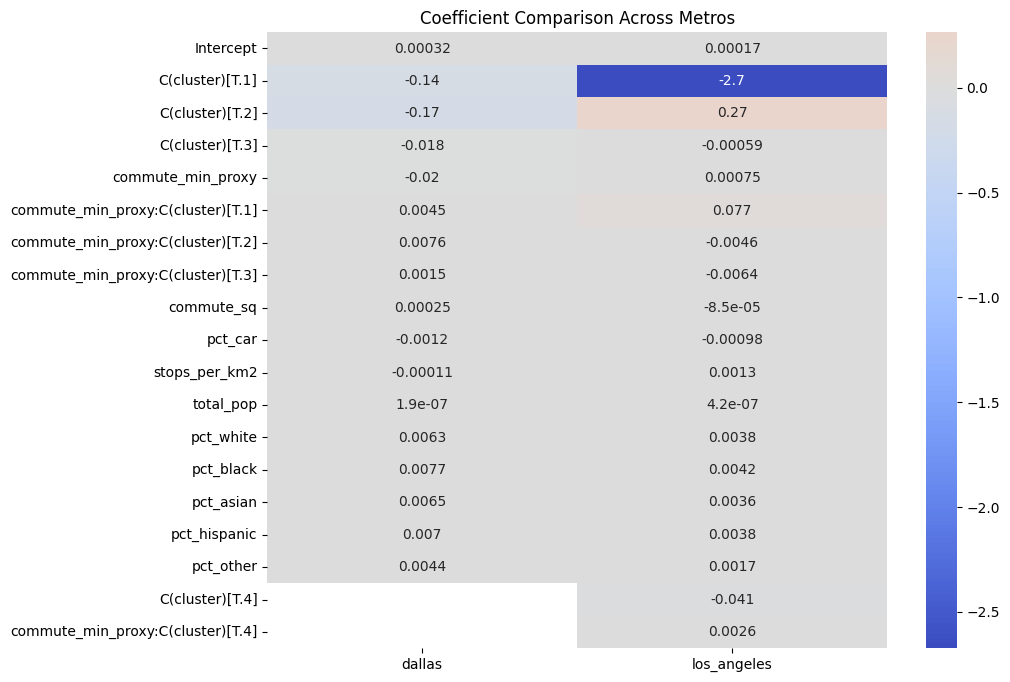

In [40]:
coef_tables = []

for metro in metros1:
    model = results_ols[(metro, "race_interaction")]
    table = model.params.to_frame(name=metro)
    coef_tables.append(table)

coef_heatmap = pd.concat(coef_tables, axis=1)

plt.figure(figsize=(10,8))
sns.heatmap(coef_heatmap, annot=True, cmap="coolwarm", center=0)
plt.title("Coefficient Comparison Across Metros")
plt.show()



Blue Variables (negative numbers) mean the variable reduces rent burden

How to interpret the Coefficient Comparisn
* Beta 1(commute_min_proxy)= linear effect
* Beta 2(commute_sq)=curvature (does rent burden rise sharply after a threshold)
Beta 1 and Beta 2 show how commute time (and its curvature) relate to rent burden

* Beta for low_income =level shift for low-income ZCTAs

* Beta for commute_x_low =whether commute’s effect on rent burden is stronger or weaker in low-income areas

The coefficient heatmap shows how commute,transit access, vehicle reliance and race produce different affordability outcomes amog the metros of Dallas and LA, ultimately revealing that these spatial nuances are more local than universal.

Since coefficients measure sensitivity, smaller coefficients in Dallas imply weaker racial and spatial segmentation while larger values in Los Angeles point too structurally entrenched affordability and demographic divides.

## Summary

Clusters help us interpret location-based inequity when it comes to transit access, car reliance, income, commute time, and race.
Interaction Beta terms show whether commute effects differ within different clusters and among ZCTAs. Race proportions show demographic effects by measuring how racial composition correlates with affordability. Adding the race composition in the model answers the question if the rent burden is higher in racially distinct areas, even after controlling for transit and commute.